# Business Intelligence II - Group 2
Created by: Marvin Bathke, Tjorven Beckedorf, Kevin Tiet and Cem Yesil

## Dataset: 2015 Flight Delays and Cancellations
Link to data source: https://www.kaggle.com/datasets/usdot/flight-delays

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import folium as fl
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, accuracy_score
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

In [4]:
airlines_data = pd.read_csv('airlines.csv')
airports_data = pd.read_csv('airports.csv')
flights_data = pd.read_csv('flights.csv', dtype={"SCHEDULED_DEPARTURE": "string",
                                                       "DEPARTURE_TIME": "string",
                                                       "WHEELS_OFF": "string",
                                                       "WHEELS_ON": "string",
                                                       "SCHEDULED_ARRIVAL": "string",
                                                       "ARRIVAL_TIME": "string"})

## 2. Data Understanding

In [5]:
airlines_data.head()

,IATA_CODE,AIRLINE
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,US,US Airways Inc.
3,F9,Frontier Airlines Inc.
4,B6,JetBlue Airways


In [6]:
airlines_data.describe()

,IATA_CODE,AIRLINE
count,14,14
unique,14,14
top,UA,United Air Lines Inc.
freq,1,1


In [7]:
airlines_data.isnull().sum()

IATA_CODE    0
AIRLINE      0
dtype: int64

In [8]:
#@title
airports_data.head()

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447


In [9]:
airports_data.describe()

,LATITUDE,LONGITUDE
count,319.000000,319.000000
mean,38.981244,-98.378964
std,8.616736,21.523492
min,13.483450,-176.646030
25%,33.652040,-110.839385
50%,39.297610,-93.403070
75%,43.154675,-82.722995
max,71.285450,-64.798560


In [10]:
airports_data.isnull().sum()

IATA_CODE    0
AIRPORT      0
CITY         0
STATE        0
COUNTRY      0
LATITUDE     3
LONGITUDE    3
dtype: int64

In [11]:
flights_data.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,0005,...,0408,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,0010,...,0741,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,0020,...,0811,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,0020,...,0756,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,0025,...,0259,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
flights_data.describe()

,YEAR,MONTH,DAY,DAY_OF_WEEK,FLIGHT_NUMBER,DEPARTURE_DELAY,TAXI_OUT,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,TAXI_IN,ARRIVAL_DELAY,DIVERTED,CANCELLED,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
count,5819079.0,5.819079e+06,5.819079e+06,5.819079e+06,5.819079e+06,5.732926e+06,5.730032e+06,5.819073e+06,5.714008e+06,5.714008e+06,5.819079e+06,5.726566e+06,5.714008e+06,5.819079e+06,5.819079e+06,1.063439e+06,1.063439e+06,1.063439e+06,1.063439e+06,1.063439e+06
mean,2015.0,6.524085e+00,1.570459e+01,3.926941e+00,2.173093e+03,9.370158e+00,1.607166e+01,1.416859e+02,1.370062e+02,1.135116e+02,8.223565e+02,7.434971e+00,4.407057e+00,2.609863e-03,1.544643e-02,1.348057e+01,7.615387e-02,1.896955e+01,2.347284e+01,2.915290e+00
std,0.0,3.405137e+00,8.783425e+00,1.988845e+00,1.757064e+03,3.708094e+01,8.895574e+00,7.521058e+01,7.421107e+01,7.223082e+01,6.077843e+02,5.638548e+00,3.927130e+01,5.102012e-02,1.233201e-01,2.800368e+01,2.143460e+00,4.816164e+01,4.319702e+01,2.043334e+01
min,2015.0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,-8.200000e+01,1.000000e+00,1.800000e+01,1.400000e+01,7.000000e+00,2.100000e+01,1.000000e+00,-8.700000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2015.0,4.000000e+00,8.000000e+00,2.000000e+00,7.300000e+02,-5.000000e+00,1.100000e+01,8.500000e+01,8.200000e+01,6.000000e+01,3.730000e+02,4.000000e+00,-1.300000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2015.0,7.000000e+00,1.600000e+01,4.000000e+00,1.690000e+03,-2.000000e+00,1.400000e+01,1.230000e+02,1.180000e+02,9.400000e+01,6.470000e+02,6.000000e+00,-5.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,0.000000e+00,2.000000e+00,3.000000e+00,0.000000e+00
75%,2015.0,9.000000e+00,2.300000e+01,6.000000e+00,3.230000e+03,7.000000e+00,1.900000e+01,1.730000e+02,1.680000e+02,1.440000e+02,1.062000e+03,9.000000e+00,8.000000e+00,0.000000e+00,0.000000e+00,1.800000e+01,0.000000e+00,1.900000e+01,2.900000e+01,0.000000e+00
max,2015.0,1.200000e+01,3.100000e+01,7.000000e+00,9.855000e+03,1.988000e+03,2.250000e+02,7.180000e+02,7.660000e+02,6.900000e+02,4.983000e+03,2.480000e+02,1.971000e+03,1.000000e+00,1.000000e+00,1.134000e+03,5.730000e+02,1.971000e+03,1.331000e+03,1.211000e+03


In [13]:
flights_data.isnull().sum()

YEAR                         0
MONTH                        0
DAY                          0
DAY_OF_WEEK                  0
AIRLINE                      0
FLIGHT_NUMBER                0
TAIL_NUMBER              14721
ORIGIN_AIRPORT               0
DESTINATION_AIRPORT          0
SCHEDULED_DEPARTURE          0
DEPARTURE_TIME           86153
DEPARTURE_DELAY          86153
TAXI_OUT                 89047
WHEELS_OFF               89047
SCHEDULED_TIME               6
ELAPSED_TIME            105071
AIR_TIME                105071
DISTANCE                     0
WHEELS_ON                92513
TAXI_IN                  92513
SCHEDULED_ARRIVAL            0
ARRIVAL_TIME             92513
ARRIVAL_DELAY           105071
DIVERTED                     0
CANCELLED                    0
CANCELLATION_REASON    5729195
AIR_SYSTEM_DELAY       4755640
SECURITY_DELAY         4755640
AIRLINE_DELAY          4755640
LATE_AIRCRAFT_DELAY    4755640
WEATHER_DELAY          4755640
dtype: int64

### Data Description

Data Description for the flights table:
- **YEAR**: The year the flight arrived.
- **MONTH**: The month the flight arrived.
- **DAY**: The day the flight arrived.
- **DAY_OF_WEEK**: The weekday the flight arrived encoded in int from 1 to 7.
- **AIRLINE**: The IATA_CODE of the airline of the flight.
- **FLIGHT_NUMBER**: Number of the flight.
- **TAIL_NUMBER**: An identification number for airplanes. 
- **ORIGIN_AIRPORT**: The IATA_CODE of the airport the airplane is scheduled to depart.
- **DESTINATION_AIRPORT**: The IATA_CODE of the airport the airplane is scheduled to land.
- **SCHEDULED_DEPARTURE**: Scheduled departure time encoded as HHMM String
- **DEPARTURE_TIME**: The time it takes from the closing of the gate to the actual wheels off. Also encoded as HHMM String.
- **DEPARTURE_DELAY**: The delay of the departure in min between the real and the planned departure.
- **TAXI_OUT**: The time duration elapsed between departure from the origin airport gate and wheels off.
- **WHEELS_OFF**: The actual time the airplane departed as HHMM String.
- **SCHEDULED_TIME**: The planned time the flight trip is needed.
- **ELAPSED_TIME**: The form TAXI_IN to TAXI_OUT.
- **AIR_TIME**: The duration between wheels_on and wheels_off.
- **DISTANCE**: Distance between the two airports.
- **WHEELS_ON**: The time point that the aircraft's wheels touch on the ground.
- **TAXI_IN**: The time duration elapsed between wheels-on and gate arrival at the destination airport.
- **SCHEDULED_ARRIVAL**: Planned arrival time as HHMM String.
- **ARRIVAL_TIME**: The time of WHEELS_IN + TAXI_IN
- **ARRIVAL_DELAY**: The delay of the arrival in min between the real and the scheduled arrival.
- **DIVERTED**: Aircraft got diverted to another airport. 0 = no; 1 = yes
- **CANCELLED**: Flight got cancelled. 0 = no ; 1 = yes.
- **CANCELLATION_REASON**: Reason why the flight is cancelled. A= Airline/Carrier, B= Weather, C= National Air System, D = Security
- **AIR_SYSTEM_DELAY**: Delay caused by air system in minutes
- **SECURITY_DELAY**: Delay caused by security in minutes
- **AIRLINE_DELAY**:  Delay caused by the airline in minutes
- **LATE_AIRCRAFT_DELAY**: Delay caused by aircraft in minutes.
- **WEATHER_DELAY**: Delay caused by weather in minutes.

In [14]:
flights_data.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,0005,...,0408,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,0010,...,0741,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,0020,...,0811,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,0020,...,0756,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,0025,...,0259,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


## 3. Data Preprocessing

### 3.1 Cleaning the data

Convert all columns to lower case

In [15]:
flights_data.columns = map(str.lower, flights_data.columns)
airlines_data.columns = map(str.lower, airlines_data.columns)
airports_data.columns = map(str.lower, airports_data.columns)

Firstly, make the date columns to an actual date. Using datetime and a dateformat is more convenient to work with.

In [16]:
flights_data["date"] = pd.to_datetime(flights_data[["year", "month", "day"]])

After that we handle the HHMM Strings and format them to also a datetime-format. 

In [17]:
def format_timestamp(to_convert):
    if pd.isna(to_convert):
      return pd.NA
    else:
      if to_convert == "2400":
        to_convert = "0000"
        return datetime.time(int(to_convert[0:2]), int(to_convert[2:4]))
      return datetime.time(int(to_convert[0:2]), int(to_convert[2:4]))
      #to_convert = pd.to_datetime(to_convert.zfill(4), errors="coerce", format="%H%M")


In [18]:
flights_data["scheduled_departure"] = flights_data["scheduled_departure"].apply(format_timestamp)
flights_data["departure_time"] = flights_data["departure_time"].apply(format_timestamp)
flights_data["wheels_off"] = flights_data["wheels_off"].apply(format_timestamp)
flights_data["wheels_on"] = flights_data["wheels_on"].apply(format_timestamp)
flights_data["scheduled_arrival"] = flights_data["scheduled_arrival"].apply(format_timestamp)
flights_data["arrival_time"] = flights_data["arrival_time"].apply(format_timestamp)

Next we can add more columns to use later for the analysis.
The `delay_difference` is the difference between the departure and arrival delay.
The `cat`-suffix maps attributes with non-numeric types to numbers.

In [19]:
flights_data["delay_difference"] = flights_data.arrival_delay - flights_data.departure_delay
flights_data['airline_cat']=flights_data['airline'].astype('category').cat.codes
flights_data['origin_airport_cat']=flights_data['origin_airport'].astype('category').cat.codes
flights_data['destination_airport_cat']=flights_data['destination_airport'].astype('category').cat.codes

# 4. Exploratory Data Analysis
Exploratory Data Analysis (EDA) aims to make Data and its inherent patterns understandable for humans (by making pretty plots).
We begin by looking at generally at all the Data. Afterwards we focus on airports and flights.

The EDA of this project consists of three parts: A general EDA, an EDA in relationship with the airline data and a third one in relation to the airports' data.
The questions /hypotheses which were created for and during the EDA are:
- Where are the airports located on a map?
- Which airport has the most departures / arrivals? Is one of the most visited airports a one-way airport?
- Which airport has the most numbers delays? 
- Which airport has the most time of delay?
- Does the number of flights correlate with the delay time? Is a high number of flights causing delays?
- Which airlines have the highest delays?
- What type of delays cause the most delay?
- Can we predict a flights destination based on its attributes?
- Can we predict the delay time based on its attributes?z

### 4.1 General EDA
First we take a look at some general metrics.

In [20]:
to_describe = ["departure_delay", "arrival_delay", "scheduled_time", "elapsed_time", "air_time", "delay_difference", "distance", 'cancelled', 'cancellation_reason',
               'air_system_delay', 'security_delay', 'airline_delay', 'late_aircraft_delay', 'weather_delay']
flights_data[to_describe].describe().applymap(lambda x: f"{x:.3f}") # describe data with pretty print

,departure_delay,arrival_delay,scheduled_time,elapsed_time,air_time,delay_difference,distance,cancelled,air_system_delay,security_delay,airline_delay,late_aircraft_delay,weather_delay
count,5732926.000,5714008.000,5819073.000,5714008.000,5714008.000,5714008.000,5819079.000,5819079.000,1063439.000,1063439.000,1063439.000,1063439.000,1063439.000
mean,9.370,4.407,141.686,137.006,113.512,-4.888,822.356,0.015,13.481,0.076,18.970,23.473,2.915
std,37.081,39.271,75.211,74.211,72.231,12.883,607.784,0.123,28.004,2.143,48.162,43.197,20.433
min,-82.000,-87.000,18.000,14.000,7.000,-201.000,21.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,-5.000,-13.000,85.000,82.000,60.000,-12.000,373.000,0.000,0.000,0.000,0.000,0.000,0.000
50%,-2.000,-5.000,123.000,118.000,94.000,-6.000,647.000,0.000,2.000,0.000,2.000,3.000,0.000
75%,7.000,8.000,173.000,168.000,144.000,1.000,1062.000,0.000,18.000,0.000,19.000,29.000,0.000
max,1988.000,1971.000,718.000,766.000,690.000,330.000,4983.000,1.000,1134.000,573.000,1971.000,1331.000,1211.000


todo insights to describe


Next we can look at histograms made from the attributes of `flight_data`.


array([[<AxesSubplot:title={'center':'year'}>,
        <AxesSubplot:title={'center':'month'}>,
        <AxesSubplot:title={'center':'day'}>,
        <AxesSubplot:title={'center':'day_of_week'}>,
        <AxesSubplot:title={'center':'flight_number'}>],
       [<AxesSubplot:title={'center':'departure_delay'}>,
        <AxesSubplot:title={'center':'taxi_out'}>,
        <AxesSubplot:title={'center':'scheduled_time'}>,
        <AxesSubplot:title={'center':'elapsed_time'}>,
        <AxesSubplot:title={'center':'air_time'}>],
       [<AxesSubplot:title={'center':'distance'}>,
        <AxesSubplot:title={'center':'taxi_in'}>,
        <AxesSubplot:title={'center':'arrival_delay'}>,
        <AxesSubplot:title={'center':'diverted'}>,
        <AxesSubplot:title={'center':'cancelled'}>],
       [<AxesSubplot:title={'center':'air_system_delay'}>,
        <AxesSubplot:title={'center':'security_delay'}>,
        <AxesSubplot:title={'center':'airline_delay'}>,
        <AxesSubplot:title={'center':'late

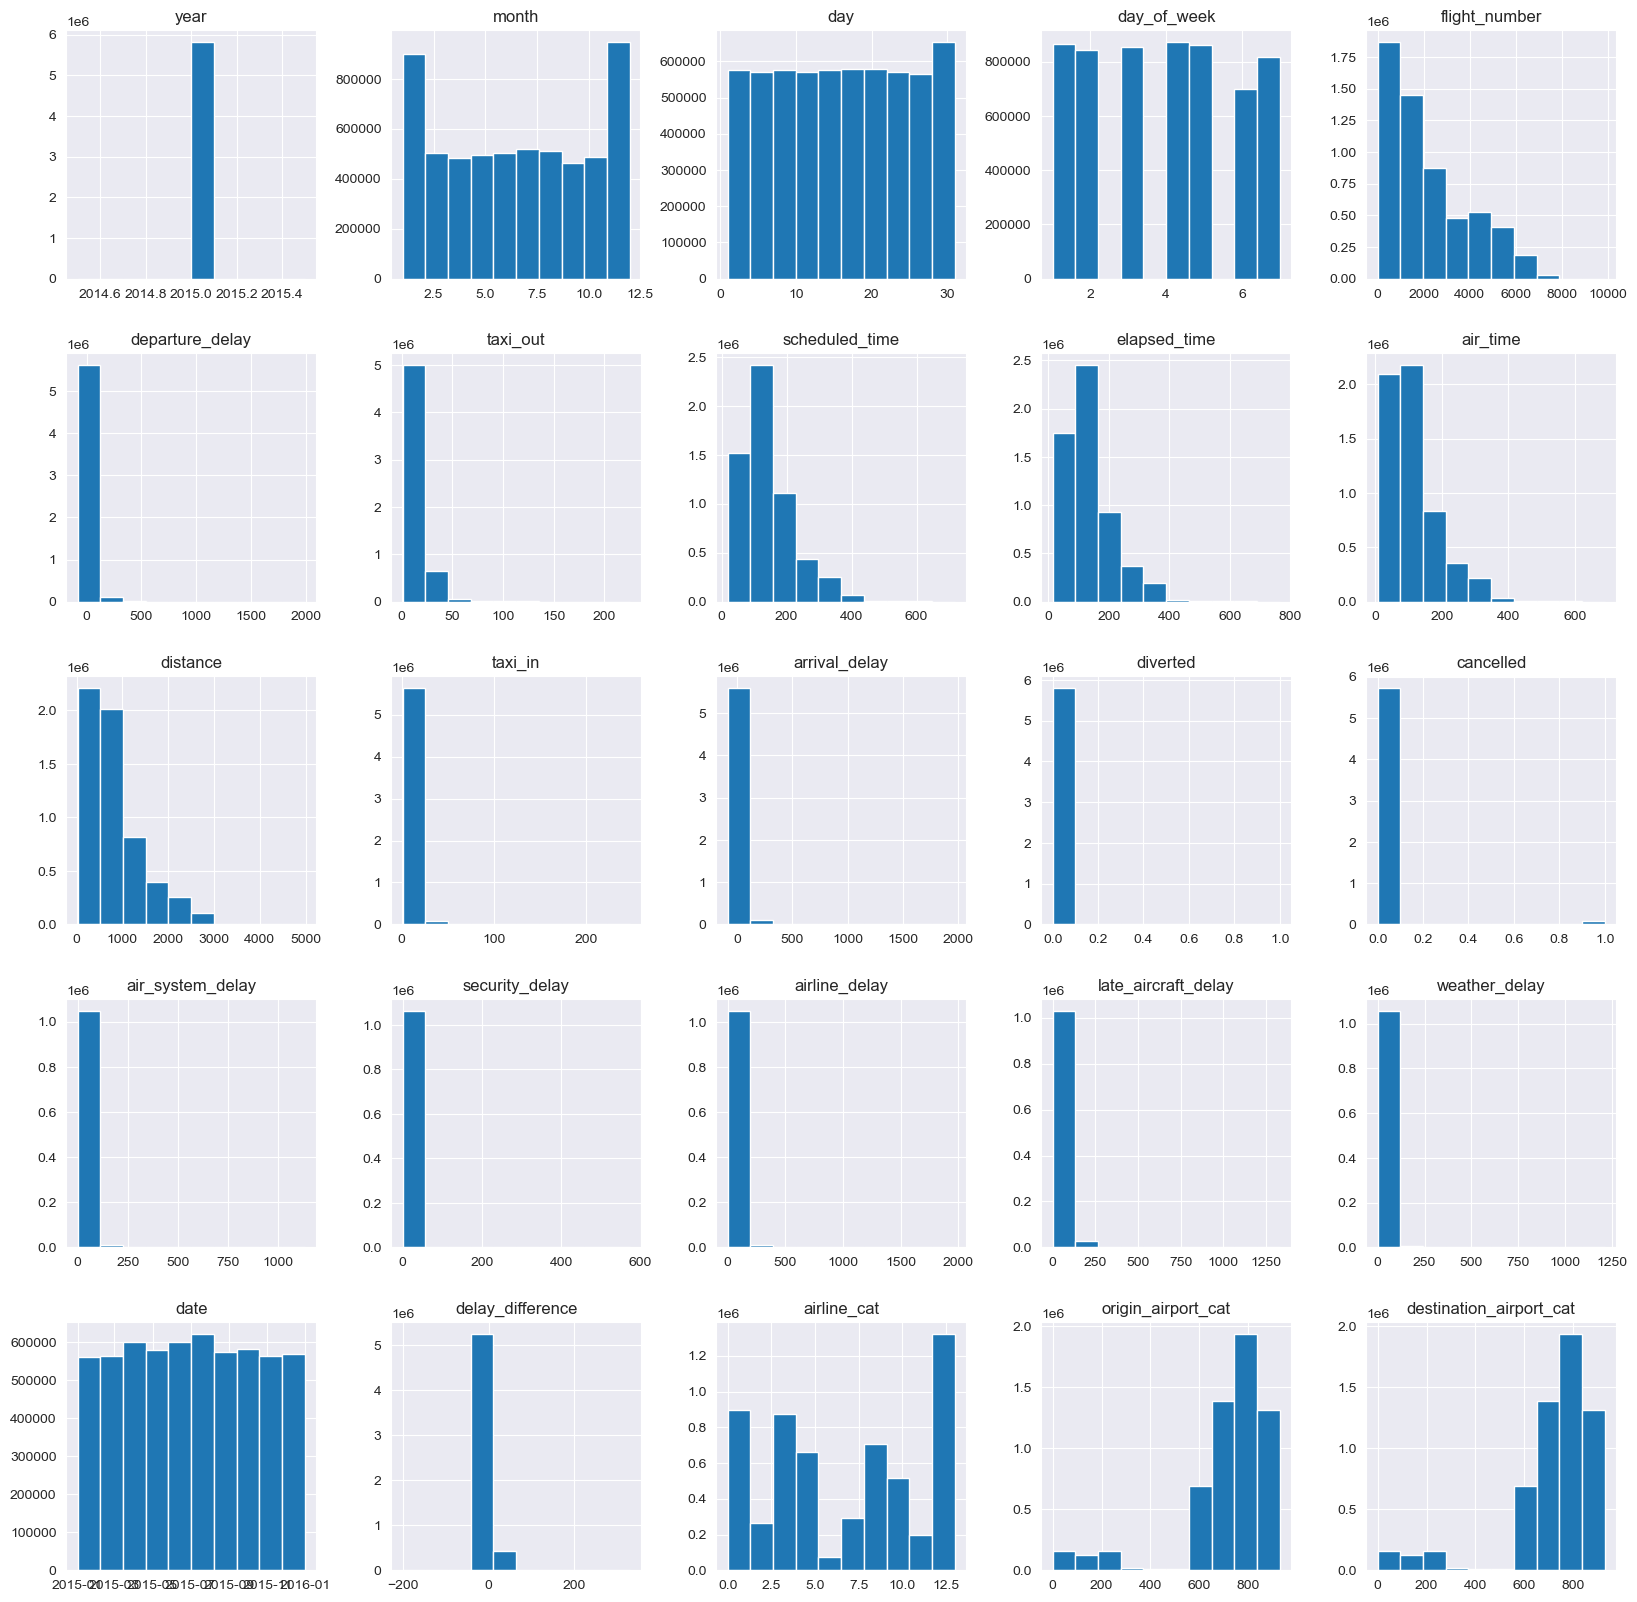

In [21]:
flights_data.hist(figsize=(20,20))

January and December have significantly more flights than the rest of the months.
The last day of the month has more flight than the other days.
There are fewer flights on Saturday.
The duration of most flights is in between of 100 and 200 minutes.
The duration of the air time of most flights is inbetween 0 and 166 minutes. Taking the general metrics account the interval is between 7 and 166 minutes.
The travel distance of most flights is in between 0 and 1000 Miles. Taking the general metrics account the interval is between 21 and 1000 Miles.

As next step we can look at the correlation between the attributes of `flight_data`. In order to achieve this, we use the pearson correlation and visualize the matrix as heatmap.

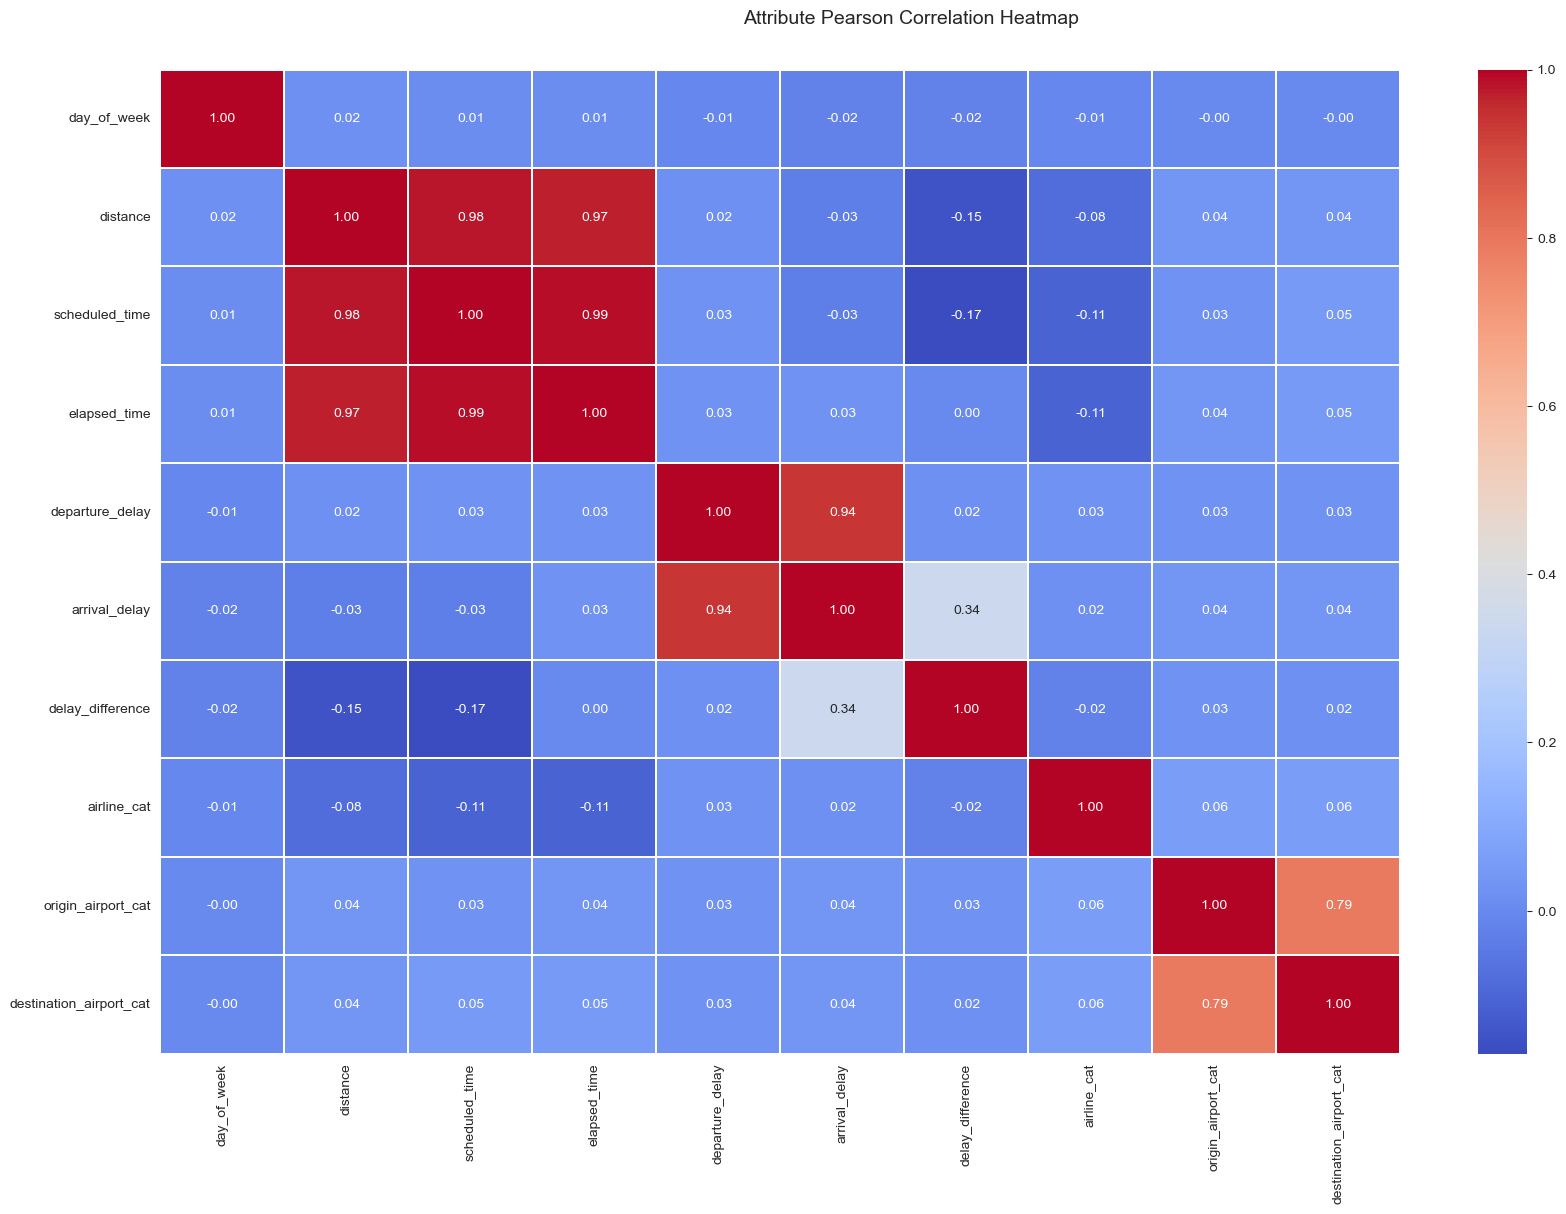

In [22]:
continuous_of_interest = ["date", "day_of_week", "distance","scheduled_time","elapsed_time", "scheduled_departure", "departure_delay","arrival_delay", "delay_difference","airline_cat", "origin_airport_cat", "destination_airport_cat"] # airport, airline
f_corr, ax_corr = plt.subplots(figsize=(20, 12))
corr = flights_data.loc[:, continuous_of_interest].corr(method="pearson")
hm_corr = sns.heatmap(round(corr,2), annot=True, ax=ax_corr, cmap="coolwarm",fmt='.2f', linewidths=.05)
f_corr.subplots_adjust(top=0.93)
t= f_corr.suptitle('Attribute Pearson Correlation Heatmap', fontsize=14)


*   `distance`, `scheduled_time` and `elapsed_time` are all correlated with each other
*   `departure_delay` and `arrival_delay` are correlated
*   `origin_airport_cat` and `destination_airport_cat` are correlated
*   `airline_cat` is negatively correlated with `distance`, `scheduled_time` and `elapsed_time`

### 4.2. Analysis of the Airport delays
The general idea about this part of EDA is it to get an insight about delays in regard to the airports.

##### In order to get a first impression of the distribution how many flights are departed from each airport, I group and count them.

In [23]:
flights_data.groupby(['origin_airport']).count()

,year,month,day,day_of_week,airline,flight_number,tail_number,destination_airport,scheduled_departure,departure_time,...,air_system_delay,security_delay,airline_delay,late_aircraft_delay,weather_delay,date,delay_difference,airline_cat,origin_airport_cat,destination_airport_cat
origin_airport,,,,,,,,,,,,,,,,,,,,,
10135,226,226,226,226,226,226,226,226,226,226,...,40,40,40,40,40,226,226,226,226,226
10136,189,189,189,189,189,189,189,189,189,182,...,21,21,21,21,21,189,181,189,189,189
10140,1712,1712,1712,1712,1712,1712,1712,1712,1712,1707,...,215,215,215,215,215,1712,1702,1712,1712,1712
10141,67,67,67,67,67,67,67,67,67,66,...,8,8,8,8,8,67,66,67,67,67
10146,82,82,82,82,82,82,82,82,82,82,...,11,11,11,11,11,82,81,82,82,82
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WRG,664,664,664,664,664,664,664,664,664,653,...,114,114,114,114,114,664,649,664,664,664
WYS,208,208,208,208,208,208,208,208,208,208,...,15,15,15,15,15,208,208,208,208,208
XNA,9283,9283,9283,9283,9283,9283,9282,9283,9283,8997,...,2024,2024,2024,2024,2024,9283,8963,9283,9283,9283


##### Investigating flights with an unusual `origin_airport`

We noticed that there are flights where the `origin_airport` is titled with a number instead of a three-lettered-code as usual.

In [24]:
number_of_flights_with_number_as_origin_airport = 0
for i in range(len(flights_data.origin_airport)):
  origin_airport_len = len(flights_data.origin_airport.loc[i]) if type(flights_data.origin_airport.loc[i]) == str else flights_data.origin_airport.loc[i]
  if origin_airport_len > 3:
    number_of_flights_with_number_as_origin_airport+=1
print(number_of_flights_with_number_as_origin_airport)

486165


In [25]:
print("Amount of flights where the origin airport is 10135:", len(flights_data[flights_data.origin_airport == 10135]))
print("Amount of flights where the origin airport is 10136:", len(flights_data[flights_data.origin_airport == 10136]))
print("Amount of flights where the origin airport is 10140:", len(flights_data[flights_data.origin_airport == 10140]))

Amount of flights where the origin airport is 10135: 226
Amount of flights where the origin airport is 10136: 189
Amount of flights where the origin airport is 10140: 1712


In [26]:
flights_data[flights_data.origin_airport == 10140]

,year,month,day,day_of_week,airline,flight_number,tail_number,origin_airport,destination_airport,scheduled_departure,...,air_system_delay,security_delay,airline_delay,late_aircraft_delay,weather_delay,date,delay_difference,airline_cat,origin_airport_cat,destination_airport_cat
4391522,2015,10,1,4,AA,2214,N425AA,10140,11298,10:55:00,...,NaN,NaN,NaN,NaN,NaN,2015-10-01,-9.0,0,2,81
4391599,2015,10,1,4,WN,432,N7704B,10140,12892,11:00:00,...,NaN,NaN,NaN,NaN,NaN,2015-10-01,1.0,13,2,165
4391873,2015,10,1,4,WN,2267,N252WN,10140,13796,11:15:00,...,NaN,NaN,NaN,NaN,NaN,2015-10-01,-9.0,13,2,210
4392020,2015,10,1,4,UA,1544,N36476,10140,12266,11:23:00,...,NaN,NaN,NaN,NaN,NaN,2015-10-01,-22.0,10,2,142
4392140,2015,10,1,4,WN,450,N299WN,10140,11292,11:30:00,...,NaN,NaN,NaN,NaN,NaN,2015-10-01,-4.0,13,2,80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4847879,2015,10,30,5,WN,400,N7827A,10140,13232,09:00:00,...,NaN,NaN,NaN,NaN,NaN,2015-10-30,-15.0,13,2,184
4848857,2015,10,30,5,WN,2733,N7741C,10140,14107,10:00:00,...,1.0,0.0,29.0,0.0,0.0,2015-10-30,1.0,13,2,227
4849052,2015,10,30,5,WN,805,N380SW,10140,12889,10:10:00,...,NaN,NaN,NaN,NaN,NaN,2015-10-30,-11.0,13,2,163
4849135,2015,10,30,5,WN,1711,N653SW,10140,11259,10:15:00,...,20.0,0.0,0.0,0.0,0.0,2015-10-30,22.0,13,2,76


When briefly looking into the flights, we noticed that all flights which have a numerical origin_airport take place in october.

In [27]:
flights_data[flights_data.month == 10]

,year,month,day,day_of_week,airline,flight_number,tail_number,origin_airport,destination_airport,scheduled_departure,...,air_system_delay,security_delay,airline_delay,late_aircraft_delay,weather_delay,date,delay_difference,airline_cat,origin_airport_cat,destination_airport_cat
4385712,2015,10,1,4,AA,1230,N3DBAA,14747,11298,00:05:00,...,NaN,NaN,NaN,NaN,NaN,2015-10-01,-29.0,0,566,386
4385713,2015,10,1,4,DL,1805,N696DL,14771,13487,00:05:00,...,NaN,NaN,NaN,NaN,NaN,2015-10-01,-21.0,3,567,507
4385714,2015,10,1,4,NK,612,N602NK,12889,13487,00:05:00,...,NaN,NaN,NaN,NaN,NaN,2015-10-01,-9.0,8,466,507
4385715,2015,10,1,4,AA,260,N3GNAA,12892,13303,00:10:00,...,NaN,NaN,NaN,NaN,NaN,2015-10-01,10.0,0,468,495
4385716,2015,10,1,4,AA,1982,N914UY,14771,11057,00:10:00,...,NaN,NaN,NaN,NaN,NaN,2015-10-01,-9.0,0,567,367
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4871872,2015,10,31,6,B6,98,N715JB,11292,12478,23:59:00,...,NaN,NaN,NaN,NaN,NaN,2015-10-31,-15.0,2,384,458
4871873,2015,10,31,6,B6,839,N834JB,12478,10732,23:59:00,...,NaN,NaN,NaN,NaN,NaN,2015-10-31,-16.0,2,458,345
4871874,2015,10,31,6,B6,1503,N907JB,12478,14843,23:59:00,...,0.0,0.0,80.0,0.0,0.0,2015-10-31,-13.0,2,458,574
4871875,2015,10,31,6,UA,1696,N68836,14747,12266,23:59:00,...,NaN,NaN,NaN,NaN,NaN,2015-10-31,-16.0,10,566,445


What we find out is that the amount of flights with a numerical `origin_airport` is equal to the amount of flights in October. We assume that this is a data collection error or systematic error in the system where the data is collected.

At the same time there seems to be no real hint how a numerical origin_airport value can be mapped to an `IATA_CODE`.

To deal with it, we are merging the `airports_data` and `flights_data`. This should remove the data, which can't be mapped to a "properly" collected airport.

At the same time we can gain more readable information. We can't just see the three-lettered-code of an airport, we also look up its name.

##### Merging flight data with airports data:

In [28]:
airports_flight_data = flights_data.merge(airports_data, left_on="origin_airport", right_on="iata_code")
airports_flight_data = airports_flight_data.rename(columns={"airport": "origin_airport_name"})
airports_flight_data = airports_flight_data.drop(columns = ["iata_code"])
airports_flight_data.head()

,year,month,day,day_of_week,airline,flight_number,tail_number,origin_airport,destination_airport,scheduled_departure,...,delay_difference,airline_cat,origin_airport_cat,destination_airport_cat,origin_airport_name,city,state,country,latitude,longitude
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,00:05:00,...,-11.0,1,625,885,Ted Stevens Anchorage International Airport,Anchorage,AK,USA,61.17432,-149.99619
1,2015,1,1,4,AS,108,N309AS,ANC,SEA,00:45:00,...,-10.0,1,625,885,Ted Stevens Anchorage International Airport,Anchorage,AK,USA,61.17432,-149.99619
2,2015,1,1,4,DL,1560,N3743H,ANC,SEA,00:45:00,...,-10.0,3,625,885,Ted Stevens Anchorage International Airport,Anchorage,AK,USA,61.17432,-149.99619
3,2015,1,1,4,AS,122,N413AS,ANC,PDX,00:50:00,...,-14.0,1,625,844,Ted Stevens Anchorage International Airport,Anchorage,AK,USA,61.17432,-149.99619
4,2015,1,1,4,AS,136,N431AS,ANC,SEA,01:35:00,...,NaN,1,625,885,Ted Stevens Anchorage International Airport,Anchorage,AK,USA,61.17432,-149.99619


Next, we drop the attributes which aren't necessary for the analysis.

In [29]:
airports_flight_data_orig = airports_flight_data.copy()

In [30]:
airports_flight_data = airports_flight_data.drop(columns = ['airline', 'flight_number', 'tail_number', 'elapsed_time', 'wheels_off', 'wheels_on', 'distance', 'taxi_in', 'taxi_out', 'day_of_week', 'air_time', 'country', 'state'])

##### We want to look at the question of which airports are the biggest in terms of the number of in-and-out-going traffic / flights:

In [31]:
number_of_flights_per_origin_airport = airports_flight_data.groupby(by='origin_airport').size()
number_of_flights_per_origin_airport = number_of_flights_per_origin_airport.sort_values(ascending=False)

number_of_flights_per_destination_airport = airports_flight_data.groupby(by='destination_airport').size()
number_of_flights_per_destination_airport = number_of_flights_per_destination_airport.sort_values(ascending=False)

In [32]:
print('Top 10 destination airports:', number_of_flights_per_destination_airport.index[:10])
print('Top 10 origin airports:', number_of_flights_per_origin_airport.index[:10])

Top 10 destination airports: Index(['ATL', 'ORD', 'DFW', 'DEN', 'LAX', 'SFO', 'PHX', 'IAH', 'LAS', 'MSP'], dtype='object', name='destination_airport')
Top 10 origin airports: Index(['ATL', 'ORD', 'DFW', 'DEN', 'LAX', 'SFO', 'PHX', 'IAH', 'LAS', 'MSP'], dtype='object', name='origin_airport')


The order of the top 10 airports is identical in comparison of `destination_airport` and `origin_airport`.

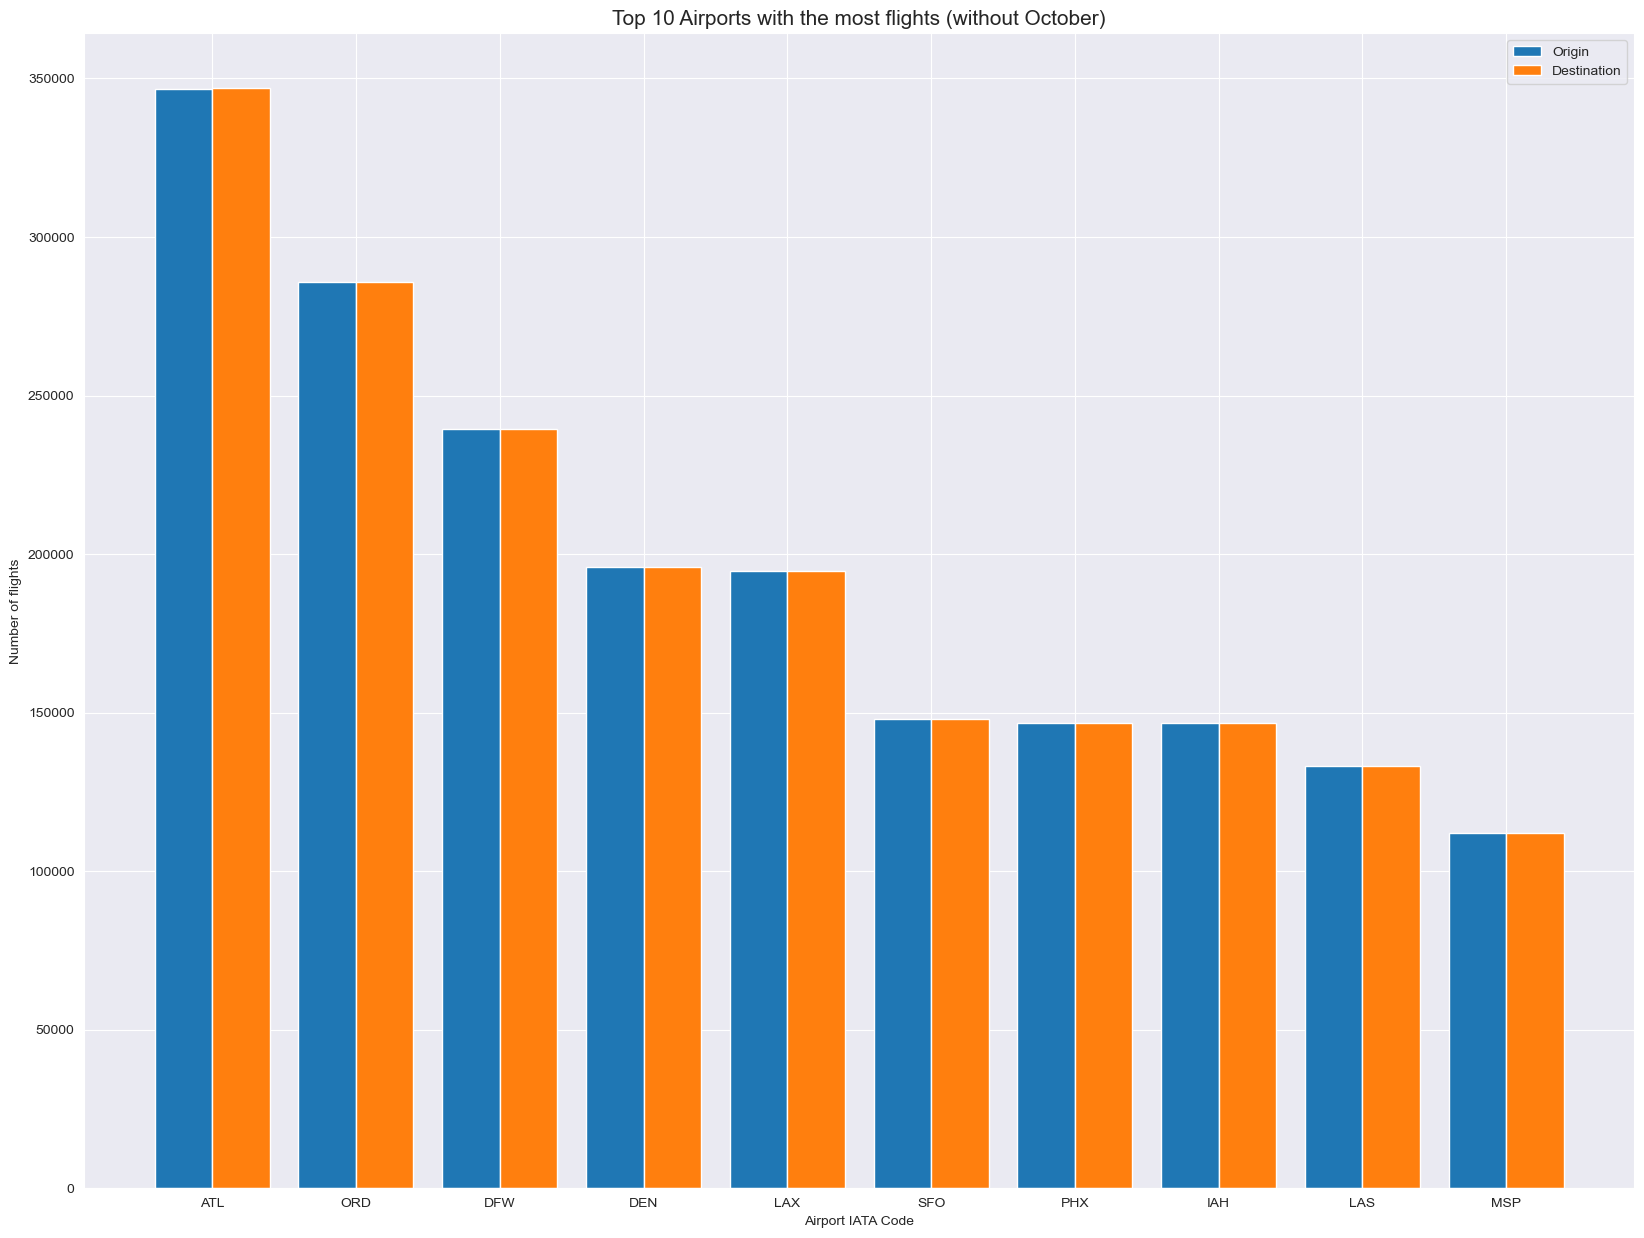

In [33]:
f, axes = plt.subplots(figsize = (20,15))
X = number_of_flights_per_origin_airport.index[:10]
y_origin = number_of_flights_per_origin_airport.values[:10]
y_dest = number_of_flights_per_destination_airport.values[:10]
  
X_axis = np.arange(10)
  
plt.bar(X_axis - 0.2, y_origin, 0.4, label = 'Origin')
plt.bar(X_axis + 0.2, y_dest, 0.4, label = 'Destination')
  
plt.xticks(X_axis, X)
plt.xlabel("Airport IATA Code")
plt.ylabel("Number of flights")
plt.title('Top 10 Airports with the most flights (without October)', fontsize=15)
plt.legend()
plt.show()

In [34]:
airports_data[airports_data['iata_code'] == 'ATL']

,iata_code,airport,city,state,country,latitude,longitude
20,ATL,Hartsfield-Jackson Atlanta International Airport,Atlanta,GA,USA,33.64044,-84.42694


In [35]:
airports_data[airports_data['iata_code'] == 'ORD']

,iata_code,airport,city,state,country,latitude,longitude
228,ORD,Chicago O'Hare International Airport,Chicago,IL,USA,41.9796,-87.90446


In [36]:
airports_data[airports_data['iata_code'] == 'DFW']

,iata_code,airport,city,state,country,latitude,longitude
86,DFW,Dallas/Fort Worth International Airport,Dallas-Fort Worth,TX,USA,32.89595,-97.0372


The bar charts show the Top 10 Airports (Origin and Destination) with the most flights out of this dataset. The month October was excluded from this visualization due to the problem that it is different encoded. In both charts can be seen that the order of origin and destination airports are the same (sorted by the amount of flights). 

The top three airports with the most in-and-outgoing flight traffic are:
- Hartsfield-Jackson Atlanta International
- Chicago O'Hare International Airport
- Dallas/Fort Worth International Airport

##### Next, we want to investigate which airports have the most delays:
To investigate this, we want to look at:
1. the time of the flight delays
2.  the number of flights with delays


##### First investigation of the delay values:
First of what can be noticed is that there are different kinds of delays:
- `departure_delay`
- `arrival_delay`
- `air_system_delay`
- `security_delay`
- `airline_delay`
- `late_aircraft_delay`
- `weather_delay`

At first glance on the NaN values at the beginning, we already saw that nearly every delay attribute had `NaN` values. Therefore, we first need to understand when those values occur.

In [37]:
airports_flight_data[airports_flight_data['cancelled'] == 0].isnull().sum()

year                             0
month                            0
day                              0
origin_airport                   0
destination_airport              0
scheduled_departure              0
departure_time                   0
departure_delay                  0
scheduled_time                   1
scheduled_arrival                0
arrival_time                  2512
arrival_delay                14354
diverted                         0
cancelled                        0
cancellation_reason        5245484
air_system_delay           4242124
security_delay             4242124
airline_delay              4242124
late_aircraft_delay        4242124
weather_delay              4242124
date                             0
delay_difference             14354
airline_cat                      0
origin_airport_cat               0
destination_airport_cat          0
origin_airport_name              0
city                             0
latitude                      4572
longitude           

In [38]:
print('Number of cancelled flights:', len(airports_flight_data[airports_flight_data['cancelled'] == 1]))
airports_flight_data[airports_flight_data['cancelled'] == 1].isnull().sum()

Number of cancelled flights: 87430


year                           0
month                          0
day                            0
origin_airport                 0
destination_airport            0
scheduled_departure            0
departure_time             83814
departure_delay            83814
scheduled_time                 5
scheduled_arrival              0
arrival_time               87430
arrival_delay              87430
diverted                       0
cancelled                      0
cancellation_reason            0
air_system_delay           87430
security_delay             87430
airline_delay              87430
late_aircraft_delay        87430
weather_delay              87430
date                           0
delay_difference           87430
airline_cat                    0
origin_airport_cat             0
destination_airport_cat        0
origin_airport_name            0
city                           0
latitude                      33
longitude                     33
dtype: int64

The first attribute (`departure_delay`) does never have a `NaN` value when a flight is not cancelled. When looking at the other attributes, they do have NaN values. Especially the attributes `air_system_delay`, `security_delay`, `airline_delay`, `late_aircraft_delay` and `weather_delay` have a huge amount of `NaN` value for not-cancelled flights. At first, an assumption was that delays of these types lead to an increased probability of cancellation. But when investigating the cancelled flights, every entry was a `NaN` value for those attributes.

##### Next we want to look at the different delay attributes and how they are related to each other:

Therefore, we looked at a row where the columns `air_system_delay`, `security_delay`, `airline_delay`, `late_aircraft_delay` and `weather_delay` are not `NaN`:

In [39]:
airports_flight_data.loc[25:35,['origin_airport','departure_delay', 'arrival_delay', 'security_delay', 'airline_delay', 'late_aircraft_delay', 'weather_delay']]

,origin_airport,departure_delay,arrival_delay,security_delay,airline_delay,late_aircraft_delay,weather_delay
25,ANC,-6.0,-17.0,NaN,NaN,NaN,NaN
26,ANC,-6.0,-18.0,NaN,NaN,NaN,NaN
27,ANC,-11.0,-30.0,NaN,NaN,NaN,NaN
28,ANC,40.0,20.0,0.0,6.0,14.0,0.0
29,ANC,-11.0,-24.0,NaN,NaN,NaN,NaN
30,ANC,-12.0,-27.0,NaN,NaN,NaN,NaN
31,ANC,-9.0,-23.0,NaN,NaN,NaN,NaN
32,ANC,39.0,21.0,0.0,18.0,3.0,0.0
33,ANC,-10.0,-31.0,NaN,NaN,NaN,NaN
34,ANC,-6.0,8.0,NaN,NaN,NaN,NaN


The following conclusion is only based on a brief look at the data.
Our presumption is that the attributes `air_system_delay`, `security_delay`, `airline_delay`, `late_aircraft_delay` and `weather_delay` are a more detailed representation of the attribute `arrival_delay`.

We chose to look only in the columns `air_system_delay`, `security_delay`, `airline_delay`, `late_aircraft_delay` and `weather_delay` due to the fact that the `arrival_delay` represents the net loss of time on a flight. Furthermore, we can get a more detailed view when looking at those attributes instead of the `departure_delay`.

As previously stated that the `arrival_delay` is only a summarization of the more detailed attributes, we can also leave this out for the next steps.

#### 1. Investigation of the time of the flight delays per airport

For the calculation of delay time it is necessary to fill the `NaN` values of the attributes `air_system_delay`, `security_delay`, `airline_delay`, `late_aircraft_delay` and `weather_delay`. Otherwise mathematical operations like building the sum wouldn't be possible.

##### NaN-fill of the airport_flight data:

This means that those values need to be transformed in order to use them for the second part of the question. We chose to fill those `NaN` values with 0.

In [40]:
airports_flight_data_na_filled_orig = airports_flight_data_orig.copy()
airports_flight_data_na_filled_orig[['air_system_delay', 'security_delay', 'airline_delay', 'late_aircraft_delay', 'weather_delay']] = airports_flight_data_na_filled_orig[['air_system_delay', 'security_delay', 'airline_delay', 'late_aircraft_delay', 'weather_delay']].fillna(value=0)
airports_flight_data_na_filled_orig.loc[:,['air_system_delay', 'security_delay', 'airline_delay', 'late_aircraft_delay', 'weather_delay']].isnull().sum()

air_system_delay       0
security_delay         0
airline_delay          0
late_aircraft_delay    0
weather_delay          0
dtype: int64

In [41]:
airports_flight_data_na_filled = airports_flight_data.copy()
airports_flight_data_na_filled[['air_system_delay', 'security_delay', 'airline_delay', 'late_aircraft_delay', 'weather_delay']] = airports_flight_data_na_filled[['air_system_delay', 'security_delay', 'airline_delay', 'late_aircraft_delay', 'weather_delay']].fillna(value=0)
airports_flight_data_na_filled.loc[:,['air_system_delay', 'security_delay', 'airline_delay', 'late_aircraft_delay', 'weather_delay']].isnull().sum()

air_system_delay       0
security_delay         0
airline_delay          0
late_aircraft_delay    0
weather_delay          0
dtype: int64

##### Investigating negative `arrival_delay`:
We also noticed that a big amount of flights show a negative value for `arrival_delay`. In this part of the analysis we want only focus on the "real" delay time. Otherwise positive and negative values could cancel each other out.

In [42]:
len(airports_flight_data_na_filled[airports_flight_data_na_filled['arrival_delay'] < 0])

3170103

In total there are more than 3 million data entries having a negative `arrival_delay`. Therefore, the impact when not handling it, could be huge.

In [43]:
airports_flight_data_na_filled.iloc[0][['arrival_delay', 'security_delay', 'air_system_delay', 'airline_delay', 'weather_delay']]

arrival_delay      -22.0
security_delay       0.0
air_system_delay     0.0
airline_delay        0.0
weather_delay        0.0
Name: 0, dtype: object

Fortunately, we found out that the detailed attributes are all set to zero if a flight is earlier than expected. That means, handling it is not necessary.

##### Creating the summed delays grouped by origin airport:

In [44]:
flight_delays_grouped_by_origin_airport_in_minutes = airports_flight_data_na_filled.loc[:,['origin_airport','air_system_delay', 'security_delay', 'airline_delay', 'late_aircraft_delay', 'weather_delay']].groupby(by='origin_airport').sum()
flight_delays_grouped_by_origin_airport_in_minutes.head()

,air_system_delay,security_delay,airline_delay,late_aircraft_delay,weather_delay
origin_airport,,,,,
ABE,7588.0,0.0,8475.0,11112.0,355.0
ABI,4253.0,46.0,8457.0,7274.0,4804.0
ABQ,36217.0,280.0,59413.0,94237.0,8935.0
ABR,1508.0,26.0,4858.0,2795.0,376.0
ABY,1212.0,0.0,4983.0,4491.0,0.0


It is already visible that the security delay and weather delay seem to be smaller than the other types of delay.

In [45]:
airports_flights_delay_types = pd.DataFrame((airports_flight_data_na_filled.groupby(["origin_airport"])["air_system_delay"].sum()/60).round(2))
airports_flights_delay_types["security_delay"] = pd.DataFrame((airports_flight_data_na_filled.groupby(["origin_airport"])["security_delay"].sum()/60).round(2))
airports_flights_delay_types["airline_delay"] = pd.DataFrame((airports_flight_data_na_filled.groupby(["origin_airport"])["airline_delay"].sum()/60).round(2))
airports_flights_delay_types["late_aircraft_delay"] = pd.DataFrame((airports_flight_data_na_filled.groupby(["origin_airport"])["late_aircraft_delay"].sum()/60).round(2))
airports_flights_delay_types["weather_delay"] = pd.DataFrame((airports_flight_data_na_filled.groupby(["origin_airport"])["weather_delay"].sum()/60).round(2))
airports_flights_delay_types["sum"] = airports_flights_delay_types[["air_system_delay", "security_delay","airline_delay", "late_aircraft_delay", "weather_delay"]].sum(axis=1)
airports_flights_delay_types = airports_flights_delay_types.sort_values("sum", ascending=False)

In [46]:
temp = pd.DataFrame()
airports_flights_delay_sum = airports_flights_delay_types["sum"]
temp['security_delay_per'] = pd.DataFrame(((airports_flights_delay_types["security_delay"] /airports_flights_delay_sum)*100).round(2))
temp["air_system_delay_per"] = pd.DataFrame(((airports_flights_delay_types["air_system_delay"] /airports_flights_delay_sum)*100).round(2))
temp["airline_delay_per"] = pd.DataFrame(((airports_flights_delay_types["airline_delay"] /airports_flights_delay_sum)*100).round(2))
temp["late_aircraft_delay_per"] = pd.DataFrame(((airports_flights_delay_types["late_aircraft_delay"] /airports_flights_delay_sum)*100).round(2))
temp["weather_delay_per"] = pd.DataFrame(((airports_flights_delay_types["weather_delay"] /airports_flights_delay_sum)*100).round(2))

In [47]:
temp

,security_delay_per,air_system_delay_per,airline_delay_per,late_aircraft_delay_per,weather_delay_per
origin_airport,,,,,
ORD,0.06,22.68,30.18,36.96,10.12
ATL,0.04,19.77,37.62,32.80,9.77
DFW,0.20,18.32,36.79,35.88,8.82
DEN,0.04,22.39,31.31,42.44,3.83
LAX,0.15,20.05,32.43,45.89,1.48
...,...,...,...,...,...
WYS,0.00,11.50,30.35,55.54,2.61
AKN,0.00,29.58,45.83,24.60,0.00
ITH,0.00,0.00,68.10,31.90,0.00


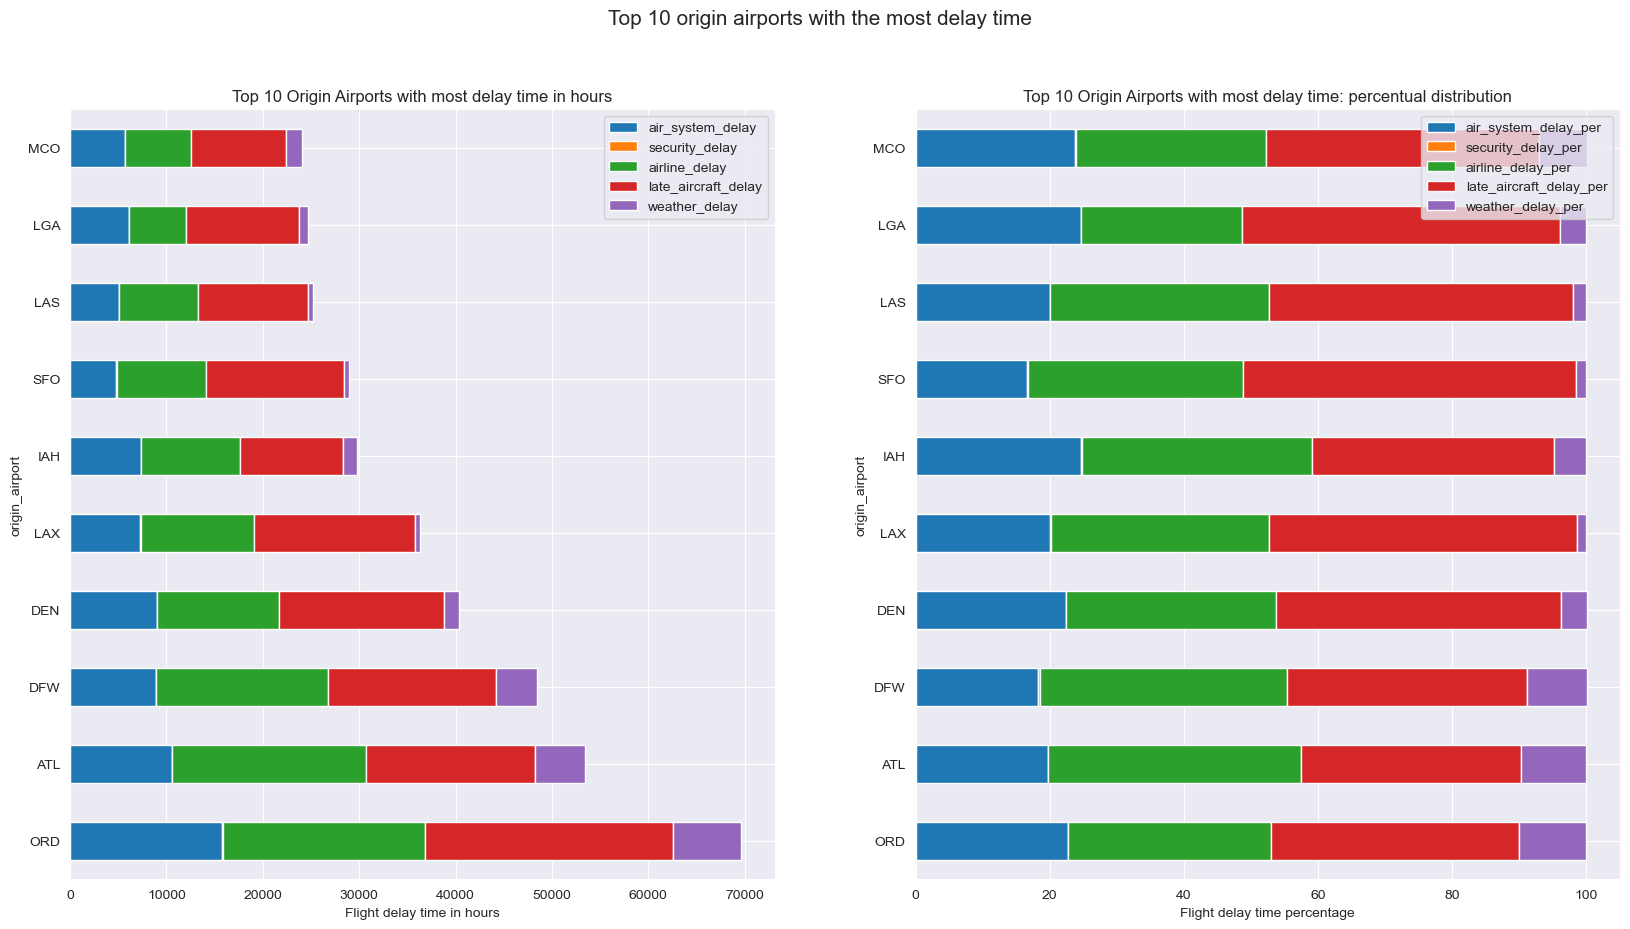

In [48]:
f, ax = plt.subplots(1, 2, figsize = (20,10))
ax[0].set(ylabel="Airport IATA Code",
       xlabel="Flight delay time in hours")

ax[0].set_title('Top 10 Origin Airports with most delay time in hours')

ax[1].set(ylim=(-0.5, 10.5), ylabel="Airport IATA Code",
       xlabel="Flight delay time percentage")
ax[1].set_title('Top 10 Origin Airports with most delay time: percentual distribution')

ax[0] = airports_flights_delay_types[['air_system_delay', 'security_delay', 'airline_delay', 'late_aircraft_delay', 'weather_delay']].iloc[:10].plot.barh(stacked=True, ax=ax[0])
ax[1] = temp[['air_system_delay_per', 'security_delay_per', 'airline_delay_per', 'late_aircraft_delay_per', 'weather_delay_per']].iloc[:10].plot(kind="barh",stacked=True, ax=ax[1])
plt.suptitle('Top 10 origin airports with the most delay time', fontsize= 15)
plt.show()

In every airport of the plot a big amount of delay time is caused by `airline_delay` and `late_aircraft_delay`. In contrast to that the `security_delay` time is just minimal. 

Comparing this rank order of the delay time to the plot with the largest amount of in- and outgoing flights, the ranking is about the same. In this plot (Top 10 origin airports with the most delay time), the airports `LGA` (LaGuardia Airport (Marine Air Terminal)) and `MCO` (Orlando International Airport) are ranked 9th and 10th, respectively. In contrast to the top 10 airports with the most flights, `PHX` (Phoenix Sky Harbor International Airport) and `MSP` (Minneapolis-Saint Paul International) are missing here.

In addition, the rank order did change a little. Here is a table showing the Top-10 rank order of both plots:

| Rank | Top 10 with most delay time | Top 10 with most flights |
|------|-----------------------------|--------------------------|
| 1    | ORD                         | ATL                      |
| 2    | ATL                         | ORD                      |
| 3    | DFW                         | DFW                      |
| 4    | DEN                         | DEN                      |
| 5    | LAX                         | LAX                      |
| 6    | IAH                         | SFO                      |
| 7    | SFO                         | PHX                      |
| 8    | LAS                         | IAH                      |
| 9    | LGA                         | LAS                      |
| 10   | MCO                         | MSP                      |

The similarity of these two diagrams can be explained by the fact that a higher number of flights also results in a higher total delay time.

##### Next, we want to look at the ratio between the delay time and number of flights. In this way, we can see what the average delay per flight is at an airport and whether it is similar to the number of flights plot.

In [49]:
airports_delay_num_flights_df = airports_flights_delay_types.merge(number_of_flights_per_origin_airport.rename('number_of_flights'), left_index=True, right_index=True)
airports_delay_num_flights_df.head()

,air_system_delay,security_delay,airline_delay,late_aircraft_delay,weather_delay,sum,number_of_flights
origin_airport,,,,,,,
ORD,15788.88,44.95,21014.00,25733.22,7043.22,69624.27,285884
ATL,10572.27,22.23,20119.88,17540.22,5224.85,53479.45,346836
DFW,8870.35,95.07,17814.43,17376.42,4269.08,48425.35,239551
DEN,9025.80,14.90,12622.98,17108.13,1543.92,40315.73,196055
LAX,7281.25,53.58,11774.97,16660.33,536.35,36306.48,194673


In [50]:
temp2 = pd.DataFrame()
number_of_flights = airports_delay_num_flights_df['number_of_flights']
temp2['security_delay_ratio'] = pd.DataFrame(((airports_delay_num_flights_df["security_delay"] /number_of_flights).round(2)))
temp2["air_system_delay_ratio"] = pd.DataFrame(((airports_delay_num_flights_df["air_system_delay"] /number_of_flights).round(2)))
temp2["airline_delay_ratio"] = pd.DataFrame(((airports_delay_num_flights_df["airline_delay"] /number_of_flights).round(2)))
temp2["late_aircraft_delay_ratio"] = pd.DataFrame(((airports_delay_num_flights_df["late_aircraft_delay"] /number_of_flights).round(2)))
temp2["weather_delay_ratio"] = pd.DataFrame(((airports_delay_num_flights_df["weather_delay"] /number_of_flights).round(2)))
temp2["sum_delay_ratio"] = pd.DataFrame(((airports_delay_num_flights_df["sum"] /number_of_flights).round(2)))
temp2 = temp2.sort_values('sum_delay_ratio', ascending=False)

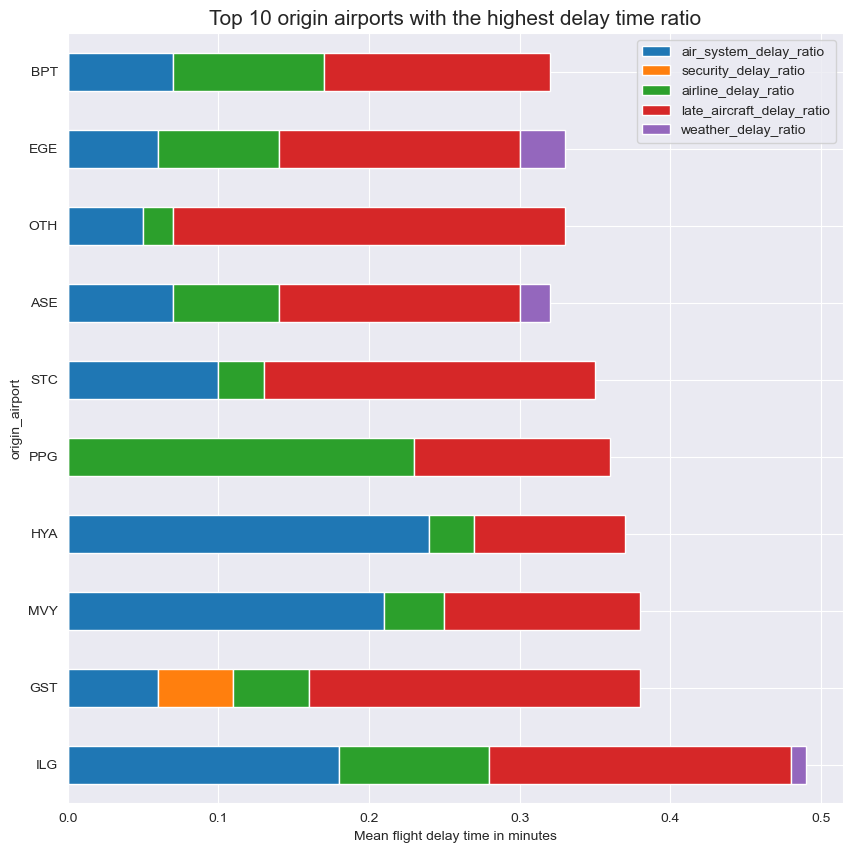

In [51]:
f, ax = plt.subplots(figsize = (10,10))
ax.set(ylabel="Airport IATA Code",
       xlabel="Mean flight delay time in minutes")

temp2[['air_system_delay_ratio', 'security_delay_ratio', 'airline_delay_ratio', 'late_aircraft_delay_ratio', 'weather_delay_ratio']].iloc[:10].plot.barh(stacked=True, ax=ax)
plt.title('Top 10 origin airports with the highest delay time ratio', fontsize= 15)
plt.show()

In [52]:
temp2.index[:10]

Index(['ILG', 'GST', 'MVY', 'HYA', 'PPG', 'STC', 'ASE', 'OTH', 'EGE', 'BPT'], dtype='object', name='origin_airport')

In [53]:
highest_delay_ratio_airports_ranking_in_num_of_flights = airports_flight_data_na_filled.groupby('origin_airport').size()
highest_delay_ratio_airports_ranking_in_num_of_flights = highest_delay_ratio_airports_ranking_in_num_of_flights.sort_values(ascending=False)
highest_delay_ratio_airports_ranking_in_num_of_flights = highest_delay_ratio_airports_ranking_in_num_of_flights.reset_index()
highest_delay_ratio_airports_ranking_in_num_of_flights = highest_delay_ratio_airports_ranking_in_num_of_flights[highest_delay_ratio_airports_ranking_in_num_of_flights.origin_airport.isin(temp2.index[:10])]
highest_delay_ratio_airports_ranking_in_num_of_flights

,origin_airport,0
137,ASE,3562
220,EGE,1241
228,BPT,973
303,OTH,275
309,MVY,205
313,PPG,107
314,ILG,100
316,HYA,83
317,STC,83
319,GST,77


Summed Number of flights of the top 10 airports with the highest delay ratio:

In [54]:
highest_delay_ratio_airports_ranking_in_num_of_flights[0].sum()

6706

In [55]:
airports_flight_data_na_filled.groupby('origin_airport').size().sort_values(ascending=False)

origin_airport
ATL    346836
ORD    285884
DFW    239551
DEN    196055
LAX    194673
        ...  
STC        83
DLG        77
GST        77
AKN        63
ITH        34
Length: 322, dtype: int64

In [56]:
temp2_ri = temp2.reset_index()

In [57]:
temp2_ri[temp2_ri['origin_airport'].isin(number_of_flights_per_origin_airport.index[:10])]

,origin_airport,security_delay_ratio,air_system_delay_ratio,airline_delay_ratio,late_aircraft_delay_ratio,weather_delay_ratio,sum_delay_ratio
41,ORD,0.0,0.06,0.07,0.09,0.02,0.24
83,DEN,0.0,0.05,0.06,0.09,0.01,0.21
104,SFO,0.0,0.03,0.06,0.10,0.00,0.20
108,IAH,0.0,0.05,0.07,0.07,0.01,0.20
117,DFW,0.0,0.04,0.07,0.07,0.02,0.20
130,LAS,0.0,0.04,0.06,0.09,0.00,0.19
135,LAX,0.0,0.04,0.06,0.09,0.00,0.19
241,PHX,0.0,0.03,0.06,0.06,0.00,0.16
256,ATL,0.0,0.03,0.06,0.05,0.02,0.15
262,MSP,0.0,0.04,0.05,0.05,0.01,0.15


The plot and table shows that none of airports out of the _Top 10 origin airports with the largest number of flights_ or _Top 10 origin airports with the most delay time_ are part of the _Top 10 origin airports with the highest delay time ratio_.

Instead, the Top 3 airports of both the number of flights and as well the plot with the most delay time in total are ranked at:

| origin_airport | Index of the delay time ratio DF |
|----------------|----------------------------------|
| ATL            | 256                              |
| ORD            | 41                               |
| DFW            | 117                              |

It was shown that the ratio of the delay time per flight seems not to be strongly connected to the number of flights. But it needs to be considered that the airports with the highest delay ratio also do not have many registered flights. The summed number of flights of the top 10 airports with the highest delay ratio is 6706. Comparing this number to only the number of flights of ATL with 346.836, these 10 airports just registered about 1,9% of the flights.

The conclusion that the number of flights and the delay ratio are not strongly connected is still valid when considering the index ranking,e.g. ATL 256 out of 322. Nevertheless, there are airports which have just a small amount of flights and are not a good representation. That is the reason to take this conclusion with caution. To back up this conclusion we want to look at the correlation between those variables in the next step.

##### Looking at the correlation between the avg delay time per flight and number of flights

In [58]:
correation_df_number_of_flights_avg_delay = temp2.merge(number_of_flights.rename('number_of_flights'), left_index=True, right_index=True)
correation_df_number_of_flights_avg_delay = correation_df_number_of_flights_avg_delay.sort_values('number_of_flights', ascending=False)
correation_df_number_of_flights_avg_delay.head()

,security_delay_ratio,air_system_delay_ratio,airline_delay_ratio,late_aircraft_delay_ratio,weather_delay_ratio,sum_delay_ratio,number_of_flights
origin_airport,,,,,,,
ATL,0.0,0.03,0.06,0.05,0.02,0.15,346836
ORD,0.0,0.06,0.07,0.09,0.02,0.24,285884
DFW,0.0,0.04,0.07,0.07,0.02,0.20,239551
DEN,0.0,0.05,0.06,0.09,0.01,0.21,196055
LAX,0.0,0.04,0.06,0.09,0.00,0.19,194673


<AxesSubplot:>

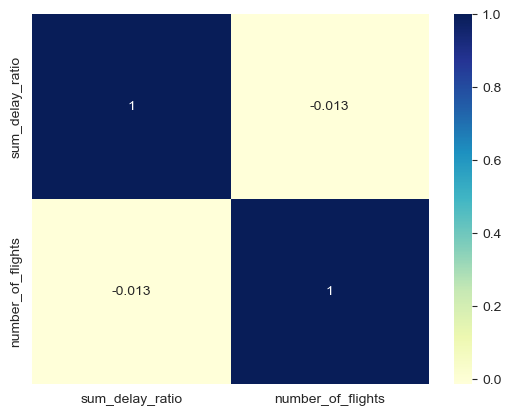

In [59]:
sns.heatmap(correation_df_number_of_flights_avg_delay[['sum_delay_ratio', 'number_of_flights']].corr(), cmap="YlGnBu", annot=True)

<AxesSubplot:xlabel='sum_delay_ratio', ylabel='number_of_flights'>

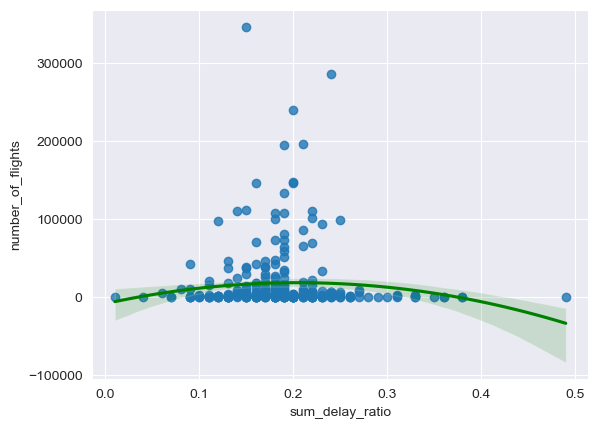

In [60]:
sns.regplot(data=correation_df_number_of_flights_avg_delay, x='sum_delay_ratio', y='number_of_flights',
                line_kws={"color": "green"},
                order=2)

The correlation matrix and scatter plot clearly shows that the correlation of these two variables is quite weak.

Reflecting on the two initial questions:
- Does the number of flights correlate with the delay time? 
- Is a high number of flights causing delays?

There seems to be a correlation between number of flights and delay time. But when considering only the average delay time per flight, there is no pattern.
That means that a high number of flights does not cause a delay.


#### 2. Investigation of the number of flights with delays per airport

In [61]:
number_of_flight_delays_grouped_by_origin_airport = airports_flight_data.loc[:,['origin_airport','security_delay', 'airline_delay', 'late_aircraft_delay', 'weather_delay']].groupby(by='origin_airport').apply(lambda x: x.count())
number_of_flight_delays_grouped_by_origin_airport = number_of_flight_delays_grouped_by_origin_airport.sort_values(ascending=False, by='security_delay')
number_of_flight_delays_grouped_by_origin_airport

,origin_airport,security_delay,airline_delay,late_aircraft_delay,weather_delay
origin_airport,,,,,
ORD,285884,66663,66663,66663,66663
ATL,346836,56462,56462,56462,56462
DFW,239551,50478,50478,50478,50478
DEN,196055,43331,43331,43331,43331
LAX,194673,40281,40281,40281,40281
...,...,...,...,...,...
AKN,63,14,14,14,14
VEL,206,7,7,7,7
DLG,77,7,7,7,7


When counting the number of the number of delays of each attribute, we have noticed that whenever one of those attributes has a delay, every other of these attributes has a value. If one of these hasn't a delay, its value is set to `0.0`. 

Due to the fact that the number of delays for each of these attributes is going to be the same, we are only plotting one of the attributes to represent the other delay attributes as well. We chose the attribute `security_delay`.

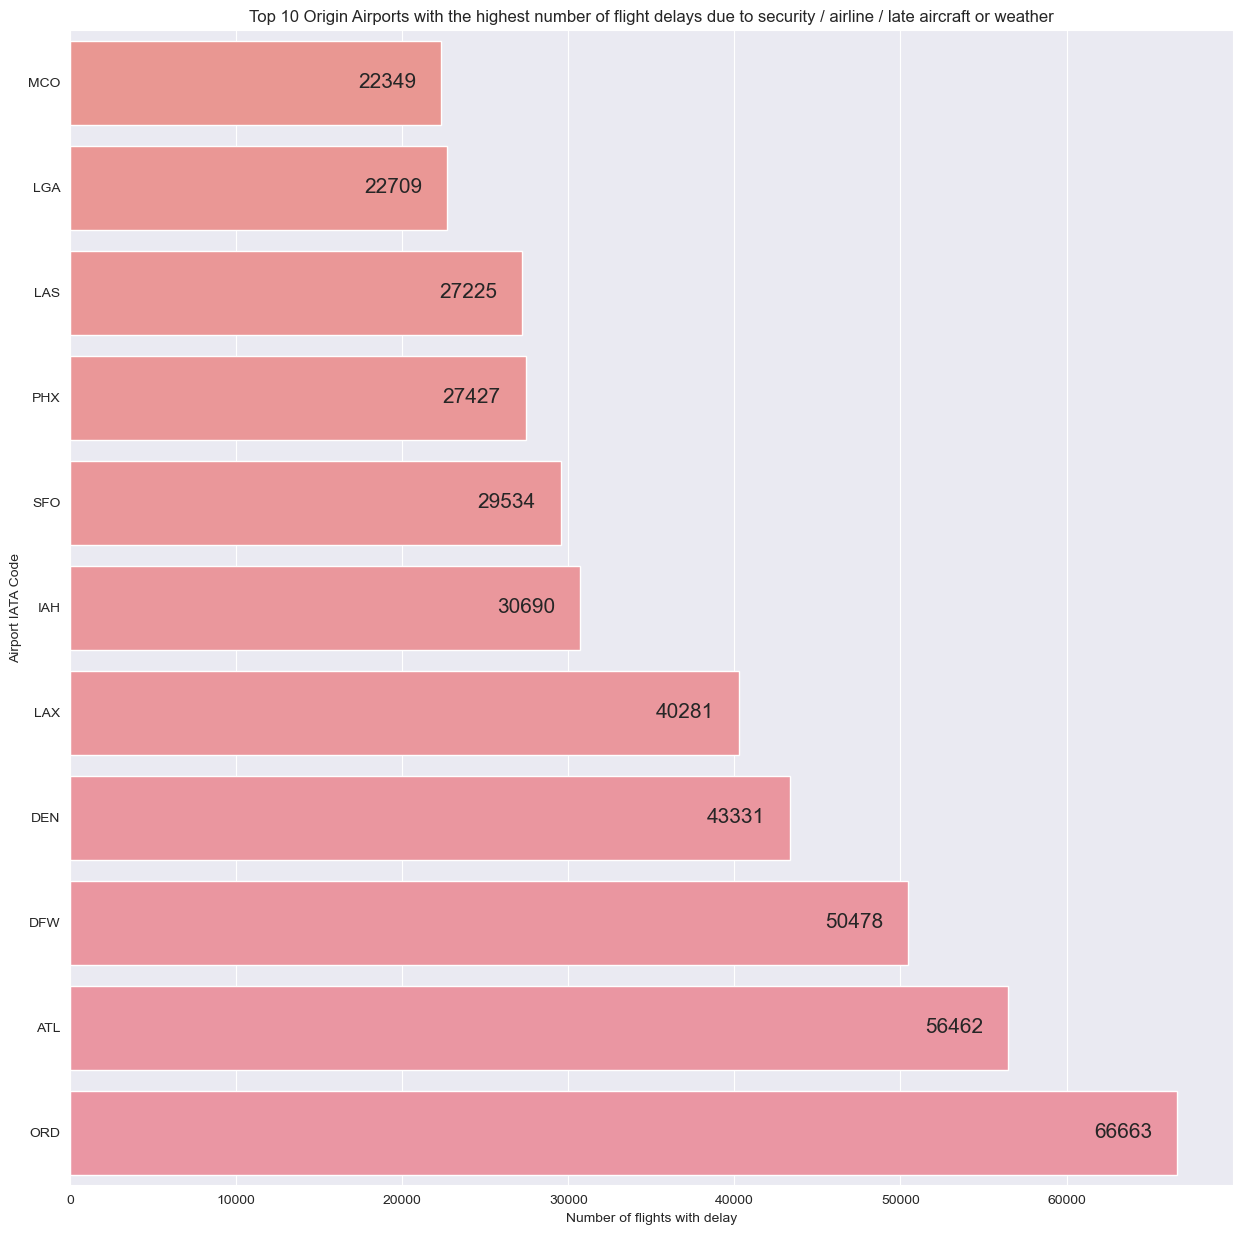

In [62]:
#@title
f, ax = plt.subplots(figsize = (15,15))
sns.barplot(y=number_of_flight_delays_grouped_by_origin_airport.index, x=number_of_flight_delays_grouped_by_origin_airport.security_delay)
ax.set(ylim=(-0.5, 10.5), ylabel="Airport IATA Code",
       xlabel="Number of flights with delay")
#ax.set_xticklabels(number_of_flights_per_origin_airport.index)
for p in ax.patches:
  ax.annotate(int(p.get_width()), (p.get_width()-5000, p.get_y()+0.35), fontsize=15)

plt.title('Top 10 Origin Airports with the highest number of flight delays due to security / airline / late aircraft or weather')
plt.show()

In [63]:
security_flight_delays_grouped_by_origin_airport_in_minutes = flight_delays_grouped_by_origin_airport_in_minutes['security_delay'].sort_values(ascending=False)
airline_flight_delays_grouped_by_origin_airport_in_minutes = flight_delays_grouped_by_origin_airport_in_minutes['airline_delay'].sort_values(ascending=False)
late_aircraft_flight_delays_grouped_by_origin_airport_in_minutes = flight_delays_grouped_by_origin_airport_in_minutes['late_aircraft_delay'].sort_values(ascending=False)
weather_flight_delays_grouped_by_origin_airport_in_minutes = flight_delays_grouped_by_origin_airport_in_minutes['weather_delay'].sort_values(ascending=False)

#### 4.2.1 Geographical Airport Distribution
1. Where are the airports located on the map?


In [64]:
airportsMapData = airports_data
airportsMapData

,iata_code,airport,city,state,country,latitude,longitude
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447
...,...,...,...,...,...,...,...
317,WRG,Wrangell Airport,Wrangell,AK,USA,56.48433,-132.36982
318,WYS,Westerly State Airport,West Yellowstone,MT,USA,44.68840,-111.11764
319,XNA,Northwest Arkansas Regional Airport,Fayetteville/Springdale/Rogers,AR,USA,36.28187,-94.30681
320,YAK,Yakutat Airport,Yakutat,AK,USA,59.50336,-139.66023


In [65]:

map = fl.Map(location=[40, -98], zoom_start=5)
airportsMapData.dropna(inplace=True)

In [66]:
for airport in range(0, len(airportsMapData)):
    fl.Marker([airportsMapData.iloc[airport]["latitude"], airportsMapData.iloc[airport]["longitude"]], popup=airportsMapData.iloc[airport]["iata_code"], tooltip=airportsMapData.iloc[airport]["airport"]).add_to(map)

map

### 4.3 Airline Flight delays


In [67]:
flights_data = flights_data.merge(airlines_data, left_on="airline", right_on="iata_code")
flights_data = flights_data.rename(columns={"airline_x": "airline_code", "airline_y": "airline_name"})
flights_data = flights_data.drop(columns = ["iata_code"])

Since we want to analyze the delay, we drop every table that we don't need for the analysis. For this we focus on the actual departure times and not on the taxi and wheel times, since the departure time is that time a passenger cares about. We also drop the cancelled flights, since there are many null values for the delay (because the flight never departed).

In [68]:
flights_data_delay = flights_data.drop(columns= ["day_of_week", "flight_number", "tail_number", 
                            "taxi_out", "wheels_off",'air_time', 'distance',
                            "wheels_on", "taxi_in"])
flights_data_delay = flights_data_delay[flights_data_delay["cancelled"] ==0]
flights_data_delay

,year,month,day,airline_code,origin_airport,destination_airport,scheduled_departure,departure_time,departure_delay,scheduled_time,...,security_delay,airline_delay,late_aircraft_delay,weather_delay,date,delay_difference,airline_cat,origin_airport_cat,destination_airport_cat,airline_name
0,2015,1,1,AS,ANC,SEA,00:05:00,23:54:00,-11.0,205.0,...,NaN,NaN,NaN,NaN,2015-01-01,-11.0,1,625,885,Alaska Airlines Inc.
1,2015,1,1,AS,SEA,ANC,00:25:00,00:24:00,-1.0,235.0,...,NaN,NaN,NaN,NaN,2015-01-01,-20.0,1,885,625,Alaska Airlines Inc.
2,2015,1,1,AS,ANC,SEA,00:45:00,00:41:00,-4.0,204.0,...,NaN,NaN,NaN,NaN,2015-01-01,-10.0,1,625,885,Alaska Airlines Inc.
3,2015,1,1,AS,ANC,PDX,00:50:00,00:46:00,-4.0,215.0,...,NaN,NaN,NaN,NaN,2015-01-01,-14.0,1,625,844,Alaska Airlines Inc.
4,2015,1,1,AS,FAI,SEA,01:15:00,01:07:00,-8.0,213.0,...,NaN,NaN,NaN,NaN,2015-01-01,5.0,1,716,885,Alaska Airlines Inc.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5819074,2015,12,31,VX,LGA,DAL,18:55:00,18:47:00,-8.0,245.0,...,NaN,NaN,NaN,NaN,2015-12-31,2.0,12,790,689,Virgin America
5819075,2015,12,31,VX,BOS,SFO,18:59:00,18:49:00,-10.0,411.0,...,NaN,NaN,NaN,NaN,2015-12-31,-36.0,12,647,886,Virgin America
5819076,2015,12,31,VX,SFO,LAS,19:40:00,19:33:00,-7.0,90.0,...,NaN,NaN,NaN,NaN,2015-12-31,-11.0,12,886,782,Virgin America
5819077,2015,12,31,VX,LAX,LAS,19:50:00,19:48:00,-2.0,65.0,...,NaN,NaN,NaN,NaN,2015-12-31,-9.0,12,784,782,Virgin America


In the next steps the describe function is used to plot some statistical values. At this point the `depature_delay` is used, since you can argue that the airline can influence the `arrival_delay` by e.g. adjusting the flight speed. This also explains a difference in these both values and why the `depature_delay` is used in the analysis.

In [69]:
statistical_values_delay = flights_data_delay["departure_delay"].groupby(flights_data["airline_name"]).describe()
statistical_values_delay

,count,mean,std,min,25%,50%,75%,max
airline_name,,,,,,,,
Alaska Airlines Inc.,171852.0,1.778455,26.350540,-82.0,-8.0,-4.0,1.0,963.0
American Airlines Inc.,715065.0,8.864029,41.802144,-68.0,-5.0,-2.0,5.0,1988.0
American Eagle Airlines Inc.,279607.0,10.014910,40.376758,-36.0,-6.0,-2.0,8.0,1544.0
Atlantic Southeast Airlines,556746.0,8.663310,38.541665,-55.0,-6.0,-3.0,4.0,1236.0
Delta Air Lines Inc.,872057.0,7.354815,36.240041,-61.0,-4.0,-1.0,4.0,1289.0
Frontier Airlines Inc.,90248.0,13.317470,49.450187,-46.0,-7.0,-2.0,12.0,1112.0
Hawaiian Airlines Inc.,76101.0,0.483489,24.546830,-27.0,-7.0,-4.0,1.0,1433.0
JetBlue Airways,262772.0,11.499049,38.476296,-31.0,-5.0,-2.0,11.0,1006.0
Skywest Airlines Inc.,578393.0,7.768222,37.745172,-56.0,-6.0,-3.0,4.0,1378.0


First lets look at the number of flight by airlines .

<AxesSubplot:xlabel='count', ylabel='airline_name'>

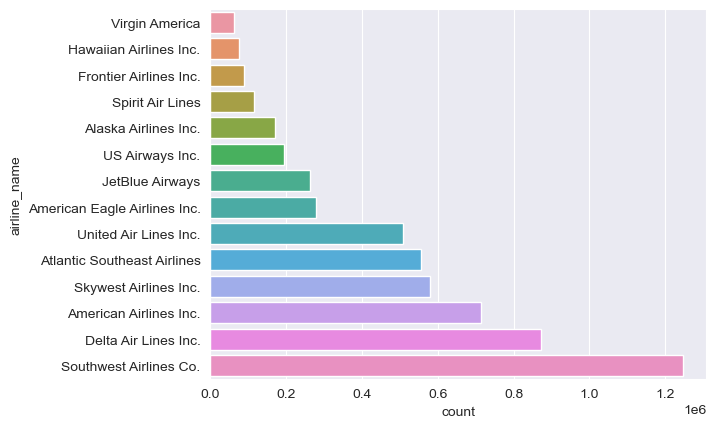

In [70]:
sns.barplot(y=statistical_values_delay.index, x ="count", data = statistical_values_delay, order =statistical_values_delay.sort_values("count").index)

We can look at the mean of the delay to evaluate which airline has the most delays.

<AxesSubplot:xlabel='mean', ylabel='airline_name'>

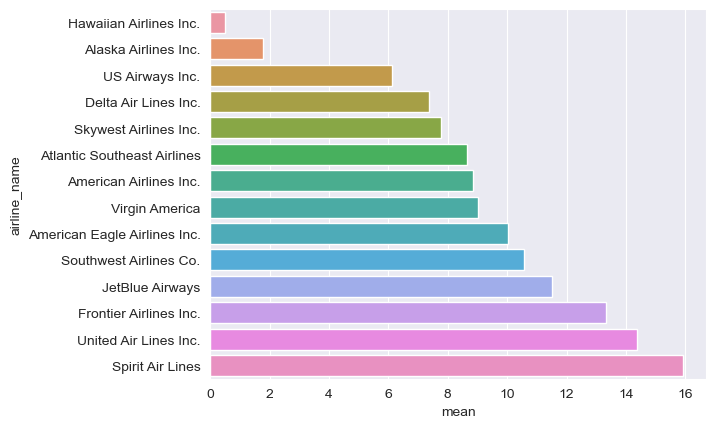

In [71]:
sns.barplot(y=statistical_values_delay.index, x ="mean", data = statistical_values_delay, order =statistical_values_delay.sort_values("mean").index)

The plot above shows the Airlines with the avg delay in min. The problem here now is, that if you look at the max values, there are some delays that are over a day long. Since this are still delays, we could split the delays into certain ranges. Since the avg delay is ~ 9min I would determine that as a short delay. After that you could argue that a delay up to an hour is a medium and over an hour could be described as a long delay.

In [72]:
rangelist = [10,60]
flights_data_delay["delay_range"] =  pd.cut(flights_data_delay['departure_delay'], 
                              [-np.inf] + sorted(rangelist) + [np.inf])

In [73]:
delay_ranges_airlines = flights_data_delay[["delay_range", "airline_name"]]

<AxesSubplot:title={'center':'Delay displayed in ranges (in minutes)'}, xlabel='airline_name'>

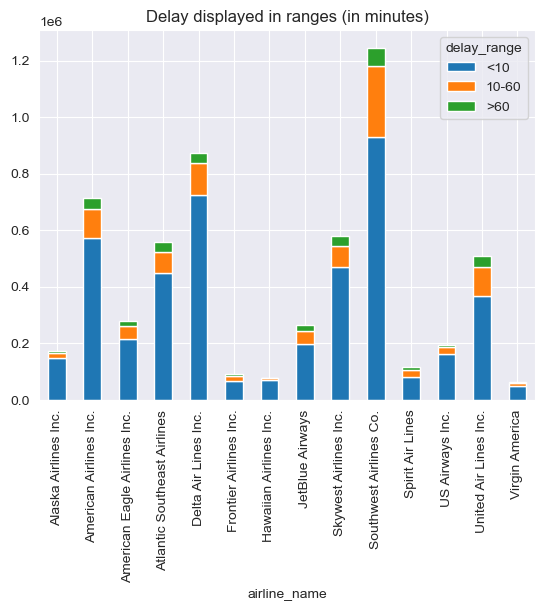

In [74]:
delay_range_count = delay_ranges_airlines.groupby(['delay_range', 'airline_name']).size().unstack(fill_value=0)
delay_range_count = delay_range_count.T
delay_range_count = delay_range_count.rename(columns={delay_range_count.columns[0]: "<10", delay_range_count.columns[1]: "10-60", delay_range_count.columns[2]: ">60"})
delay_range_count.plot(kind="bar", title="Delay displayed in ranges (in minutes)",stacked=True)


<AxesSubplot:xlabel='airline_name'>

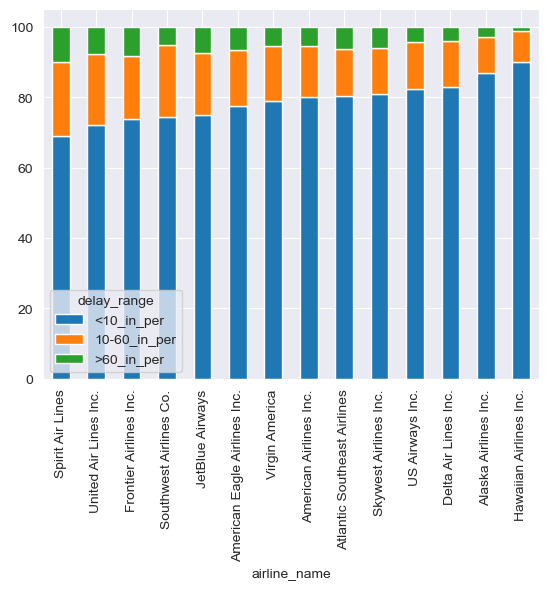

In [75]:
delay_range_count["sum_delays"] = delay_range_count[["<10","10-60", ">60"]].sum(axis=1)
delay_range_count["<10_in_per"] = ((delay_range_count["<10"] /delay_range_count["sum_delays"])*100).round(2)
delay_range_count["10-60_in_per"] = ((delay_range_count["10-60"] /delay_range_count["sum_delays"])*100).round(2)
delay_range_count[">60_in_per"] = ((delay_range_count[">60"] /delay_range_count["sum_delays"])*100).round(2)

delay_range_count_percent = delay_range_count.drop(columns=["<10","10-60", ">60", "sum_delays"])
delay_range_count_percent = delay_range_count_percent.sort_values("<10_in_per")
delay_range_count_percent.plot(kind="bar", stacked=True)

This gives us some insights why the airlines haves the highest means. Spirit Airlines have ~10% of the flights with a delay of more than an hour and by this have the highest amount of long delays. On second place with the highest amount of long delays is Frontier Airlines Inc., shortly followed by United Airlines Inc and JetBlue Airways. One could argue that Shortwest Airlines Co. are not in the top five worst Airlines this time, since they manage to have only ~6% long delays even though they have the highest flight volume. Also, the comparison of some Airlines have to be viewed carefully, since the flight volume of e.g. Hawaiian Airlines Inc is ~90% less than the flight volume of Spirit Airlines.

In the next step, the different type of delays get evaluated. To get an insight about we count the numbers of delay and

In [76]:
flights_delay_types = pd.DataFrame((flights_data_delay.groupby(["airline_name"])["air_system_delay"].sum()/60).round(2))
flights_delay_types["security_delay"] = pd.DataFrame((flights_data_delay.groupby(["airline_name"])["security_delay"].sum()/60).round(2))
flights_delay_types["airline_delay"] = pd.DataFrame((flights_data_delay.groupby(["airline_name"])["airline_delay"].sum()/60).round(2))
flights_delay_types["late_aircraft_delay"] = pd.DataFrame((flights_data_delay.groupby(["airline_name"])["late_aircraft_delay"].sum()/60).round(2))
flights_delay_types["weather_delay"] = pd.DataFrame((flights_data_delay.groupby(["airline_name"])["weather_delay"].sum()/60).round(2))
flights_delay_types = flights_delay_types.sort_values("airline_delay")

<AxesSubplot:ylabel='airline_name'>

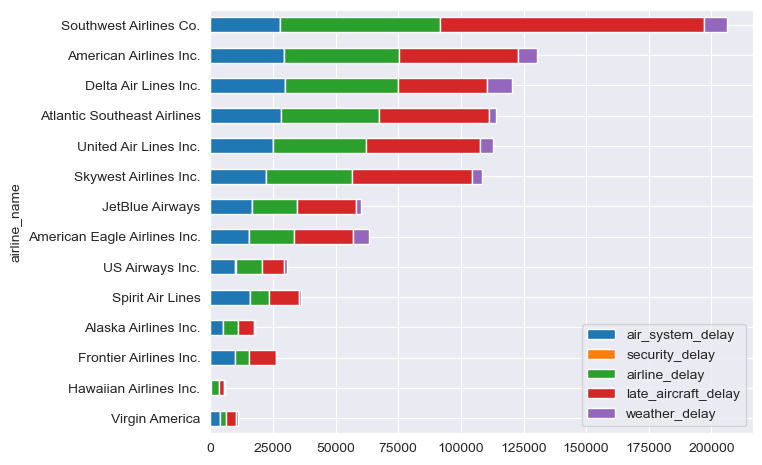

In [77]:
flights_delay_types.plot(kind="barh", stacked=True, figsize=(7,5.5))

As you can see the most time of delays comes form the  late_aircraft_delay. Still you could argue that an aircraft can be late, because of every other type of delay, e.g. an aircraft is grounded because of the weather or a security reason and is scheduled to flight again shortly after landing, it would be late due to another issue. By that conclusion the reason for the most time of delay is because of the airline, shortly followed by air_system_delays. Surprisingly, the delays because of the weather are quite rare in comparison to the just mentioned delays. Security reasons seem to cause the least time for delay and are pretty rare. 

In [78]:
flights_delay_types["sum"] = flights_delay_types[["air_system_delay", "security_delay","airline_delay", "late_aircraft_delay", "weather_delay"]].sum(axis=1)

<AxesSubplot:ylabel='airline_name'>

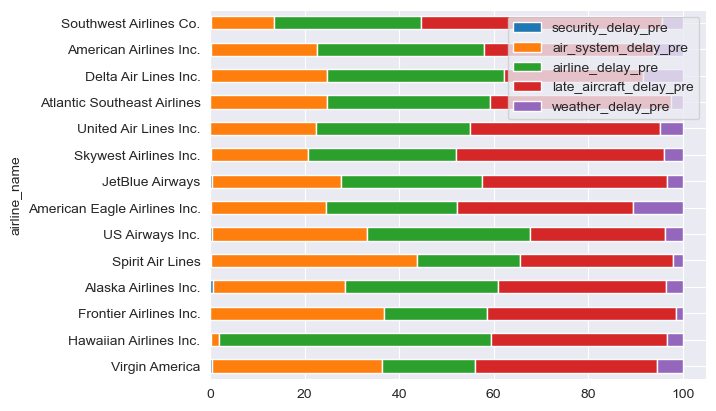

In [79]:
temp = pd.DataFrame()
temp = pd.DataFrame(((flights_delay_types["security_delay"] /flights_delay_types["sum"])*100).round(2))
temp["air_system_delay_pre"] = pd.DataFrame(((flights_delay_types["air_system_delay"] /flights_delay_types["sum"])*100).round(2))
temp["airline_delay_pre"] = pd.DataFrame(((flights_delay_types["airline_delay"] /flights_delay_types["sum"])*100).round(2))
temp["late_aircraft_delay_pre"] = pd.DataFrame(((flights_delay_types["late_aircraft_delay"] /flights_delay_types["sum"])*100).round(2))
temp["weather_delay_pre"] = pd.DataFrame(((flights_delay_types["weather_delay"] /flights_delay_types["sum"])*100).round(2))
temp = temp.rename(columns={temp.columns[0]: "security_delay_pre"})
temp.plot(kind="barh",stacked=True)

As you can see, the plot represents that what was described in the previous cell, but this time its put in percentages values.  

### Conclusion about delays in relation to airlines

The general idea about this part of EDA was to get an insight about delays in regard to the airlines. First, the `airline_name` gets added to the `flights_data`, because the name of the airline makes much more sense for displaying purposes. In the next step, columns that are not needed for the analysis are dropped and the `flights_data` get grouped by the `airline_name` to aggregate data based on the different airlines. 

The first thing displayed is the volume of the airlines. As shown in the plot, there is a huge difference in the volume between airlines. Still even *Virgin America* with the lowest value has more than ~60.000 flights on record, but in comparison to the flight volume over ~1.2 million from *Southwest Airlines Co.* it is small. This could be a factor in comparing the airlines with each other.

In the next plot mean values of the `depature_delay` of the airlines are shown. The `depature_delay` is used and not the `arrival_delay` because the airline can influence the `arrival_delay` by e.g. increasing the flying speed or similar. Since we want to compare values, the `departure_delay` is used, since it is much harder for an airline to influence that. Based on this the airlines with the most delay are *Spirit Air Lines* with a mean value of ~16 minutes, *United Air Lines Inc.* with a little over 14 minutes and closely followed by *Frontier Airlines Inc.* with around 13 minutes.

The problem with the mean values are, that some delays are over a day long, which could influence the mean pretty heavily, if there are more than just a few. To get a look at this, the delays are split into groups, defined as less than 10 minutes as a short delay, 10 to 60 minutes as a medium delay and more than 60 minutes as a long delay. To get a good overview of how many flights are delayed in the groups, the next plot shows the distribution of the delays in percentage. By this you can see how many of all flights had a short,medium or long delay grouped by the airlines. One could argue, that the airlines with the least short delays has the more medium and long delays. Looking at that, the worst airline is *Spirit Air Lines* with roughly 70% short delays, ~21% medium delays and nearly 10% long delays, followed by *United Air Lines* with around 72% short delays, 20% and around 8% long delays. On the third place of the worst airlines is *Frontier Airlines Inc.* with ~74% short delays, nearly 18% medium delays and 8% long delays. By looking at these both factors the airlines with the most delays based on the mean and distribution the duration of the delay are:
1. Spirit Air Lines
2. United Air Liens
3. Frontier Air Lines Inc.

# 5. Predicting flight delays with ML


Since the EDA focused on delays, the main goal of the ML model to implement should be to predict a delay. In this case the model should be able to predict the flight delay. After getting 3 weeks of training data, the model they should be able to predict the delays of the last week. The decision was made to take the *United Air Lines Inc.* because it's the one with the most flights on record from the top 3 most delayed airlines. The month August was randomly chosen.

In [80]:
flights_data_swa = flights_data[flights_data["airline_name"] == "Southwest Airlines Co."]
flights_data_to_predict = flights_data_swa.copy(deep=True)
flights_data_to_predict = flights_data_to_predict[flights_data_to_predict["month"] == 8]
flights_data_to_predict = flights_data_to_predict[flights_data_to_predict["cancelled"] == 0]
flights_data_to_predict = flights_data_to_predict.reset_index()
flights_data_to_predict

,index,year,month,day,day_of_week,airline_code,flight_number,tail_number,origin_airport,destination_airport,...,security_delay,airline_delay,late_aircraft_delay,weather_delay,date,delay_difference,airline_cat,origin_airport_cat,destination_airport_cat,airline_name
0,5232315,2015,8,1,6,WN,3657,N963WN,CMH,MCO,...,NaN,NaN,NaN,NaN,2015-08-01,-10.0,13,675,801,Southwest Airlines Co.
1,5232316,2015,8,1,6,WN,840,N935WN,DEN,MCI,...,NaN,NaN,NaN,NaN,2015-08-01,-1.0,13,693,800,Southwest Airlines Co.
2,5232317,2015,8,1,6,WN,2113,N421LV,HOU,LGA,...,NaN,NaN,NaN,NaN,2015-08-01,-14.0,13,751,790,Southwest Airlines Co.
3,5232318,2015,8,1,6,WN,4456,N904WN,IND,FLL,...,NaN,NaN,NaN,NaN,2015-08-01,-21.0,13,765,722,Southwest Airlines Co.
4,5232319,2015,8,1,6,WN,4423,N684WN,IND,MCO,...,NaN,NaN,NaN,NaN,2015-08-01,-3.0,13,765,801,Southwest Airlines Co.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107118,5340489,2015,8,31,1,WN,2793,N602SW,BWI,PIT,...,NaN,NaN,NaN,NaN,2015-08-31,-5.0,13,659,851,Southwest Airlines Co.
107119,5340490,2015,8,31,1,WN,1333,N282WN,BWI,SDF,...,NaN,NaN,NaN,NaN,2015-08-31,-19.0,13,659,884,Southwest Airlines Co.
107120,5340491,2015,8,31,1,WN,1996,N7815L,HOU,MDW,...,NaN,NaN,NaN,NaN,2015-08-31,-5.0,13,751,803,Southwest Airlines Co.
107121,5340492,2015,8,31,1,WN,2933,N439WN,HOU,STL,...,NaN,NaN,NaN,NaN,2015-08-31,-20.0,13,751,902,Southwest Airlines Co.


Drop unnecessary columns and columns with NaN values

In [81]:
flights_data_to_predict = flights_data_to_predict.drop(columns = ["airline_code", "diverted", "cancelled",
                                                                 "cancellation_reason", "air_system_delay",
                                                                 "security_delay", "airline_delay", "late_aircraft_delay",
                                                                 "weather_delay", "airline_name", "arrival_delay", "index",
                                                                 "elapsed_time", "air_time", "taxi_in", "delay_difference"
                                                                 ])

In [82]:
stat_predict = pd.DataFrame(flights_data_to_predict["departure_delay"].describe())
stat_predict

,departure_delay
count,107123.000000
mean,11.732046
std,33.606634
min,-18.000000
25%,-3.000000
50%,0.000000
75%,11.000000
max,620.000000


<AxesSubplot:ylabel='Frequency'>

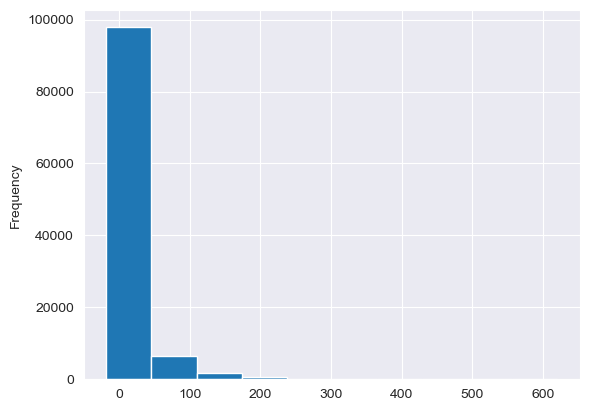

In [83]:
flights_data_to_predict["departure_delay"].plot(kind="hist")

To get more accurate results, it could be wise to filter out outliers. First idea was to only use the delays that are less than 60 minutes.

In [84]:
stat_predict = pd.DataFrame(flights_data_to_predict["departure_delay"][flights_data_to_predict["departure_delay"]<60].describe())
stat_predict

,departure_delay
count,100397.000000
mean,4.673795
std,13.183713
min,-18.000000
25%,-3.000000
50%,-1.000000
75%,7.000000
max,59.000000


<AxesSubplot:ylabel='Frequency'>

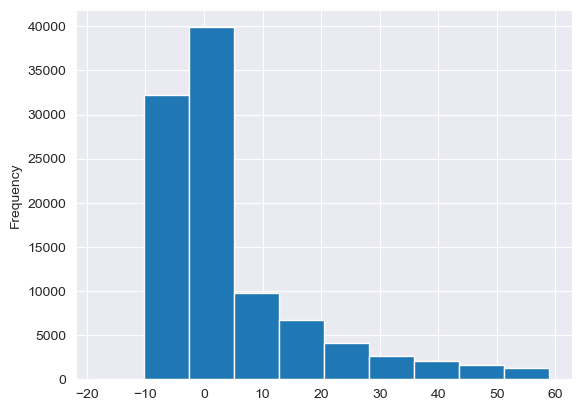

In [85]:
flights_data_to_predict["departure_delay"][flights_data_to_predict["departure_delay"]<60].plot(kind="hist")

By filtering the delays to under 60 minutes, we lose around 10% but on the other hand have a better distribution of the delays and probably get better prediction results.

In [86]:
flights_data_to_predict = flights_data_to_predict[flights_data_to_predict["departure_delay"]<60]
flights_data_to_predict

,year,month,day,day_of_week,flight_number,tail_number,origin_airport,destination_airport,scheduled_departure,departure_time,...,wheels_off,scheduled_time,distance,wheels_on,scheduled_arrival,arrival_time,date,airline_cat,origin_airport_cat,destination_airport_cat
0,2015,8,1,6,3657,N963WN,CMH,MCO,05:30:00,05:29:00,...,05:38:00,125.0,802,07:18:00,07:35:00,07:24:00,2015-08-01,13,675,801
1,2015,8,1,6,840,N935WN,DEN,MCI,05:30:00,05:29:00,...,05:47:00,90.0,533,07:54:00,08:00:00,07:58:00,2015-08-01,13,693,800
2,2015,8,1,6,2113,N421LV,HOU,LGA,05:30:00,05:30:00,...,05:40:00,210.0,1428,09:36:00,10:00:00,09:46:00,2015-08-01,13,751,790
3,2015,8,1,6,4456,N904WN,IND,FLL,05:30:00,05:26:00,...,05:38:00,165.0,1005,07:44:00,08:15:00,07:50:00,2015-08-01,13,765,722
4,2015,8,1,6,4423,N684WN,IND,MCO,05:30:00,05:27:00,...,05:41:00,130.0,829,07:28:00,07:40:00,07:34:00,2015-08-01,13,765,801
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107117,2015,8,31,1,660,N749SW,BWI,FNT,22:15:00,22:07:00,...,22:23:00,90.0,452,23:23:00,23:45:00,23:28:00,2015-08-31,13,659,723
107118,2015,8,31,1,2793,N602SW,BWI,PIT,22:15:00,22:07:00,...,22:18:00,55.0,210,22:52:00,23:10:00,22:57:00,2015-08-31,13,659,851
107119,2015,8,31,1,1333,N282WN,BWI,SDF,22:20:00,22:18:00,...,22:26:00,105.0,495,23:40:00,00:05:00,23:44:00,2015-08-31,13,659,884
107120,2015,8,31,1,1996,N7815L,HOU,MDW,22:20:00,22:15:00,...,22:27:00,140.0,937,00:24:00,00:40:00,00:30:00,2015-08-31,13,751,803


First we need to convert the strings into integer representations

In [87]:
string_columns = ["tail_number","origin_airport","destination_airport"] # "airline_name"
for c in string_columns:
    flights_data_to_predict[c] = pd.factorize(flights_data_to_predict[c])[0]
flights_data_to_predict

,year,month,day,day_of_week,flight_number,tail_number,origin_airport,destination_airport,scheduled_departure,departure_time,...,wheels_off,scheduled_time,distance,wheels_on,scheduled_arrival,arrival_time,date,airline_cat,origin_airport_cat,destination_airport_cat
0,2015,8,1,6,3657,0,0,0,05:30:00,05:29:00,...,05:38:00,125.0,802,07:18:00,07:35:00,07:24:00,2015-08-01,13,675,801
1,2015,8,1,6,840,1,1,1,05:30:00,05:29:00,...,05:47:00,90.0,533,07:54:00,08:00:00,07:58:00,2015-08-01,13,693,800
2,2015,8,1,6,2113,2,2,2,05:30:00,05:30:00,...,05:40:00,210.0,1428,09:36:00,10:00:00,09:46:00,2015-08-01,13,751,790
3,2015,8,1,6,4456,3,3,3,05:30:00,05:26:00,...,05:38:00,165.0,1005,07:44:00,08:15:00,07:50:00,2015-08-01,13,765,722
4,2015,8,1,6,4423,4,3,0,05:30:00,05:27:00,...,05:41:00,130.0,829,07:28:00,07:40:00,07:34:00,2015-08-01,13,765,801
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107117,2015,8,31,1,660,205,57,82,22:15:00,22:07:00,...,22:23:00,90.0,452,23:23:00,23:45:00,23:28:00,2015-08-31,13,659,723
107118,2015,8,31,1,2793,8,57,26,22:15:00,22:07:00,...,22:18:00,55.0,210,22:52:00,23:10:00,22:57:00,2015-08-31,13,659,851
107119,2015,8,31,1,1333,224,57,58,22:20:00,22:18:00,...,22:26:00,105.0,495,23:40:00,00:05:00,23:44:00,2015-08-31,13,659,884
107120,2015,8,31,1,1996,442,2,7,22:20:00,22:15:00,...,22:27:00,140.0,937,00:24:00,00:40:00,00:30:00,2015-08-31,13,751,803


Handle dates for regression

In [88]:
def convert_to_ordinal(timestamp):
    return (timestamp.hour * 60 + timestamp.minute)*60 +timestamp.second

drop empty values and format the rest of the dates

In [89]:
date_columns = ["scheduled_departure", "departure_time", "wheels_off", "wheels_on", "scheduled_arrival", "arrival_time"]
flights_data_to_predict = flights_data_to_predict[flights_data_to_predict["wheels_on"].notna()]

In [90]:
for c in date_columns:
    print(type(flights_data_to_predict[c].iloc[0]))
    flights_data_to_predict[c] = flights_data_to_predict[c].apply(convert_to_ordinal)
flights_data_to_predict

<class 'datetime.time'>
<class 'datetime.time'>
<class 'datetime.time'>
<class 'datetime.time'>
<class 'datetime.time'>
<class 'datetime.time'>


,year,month,day,day_of_week,flight_number,tail_number,origin_airport,destination_airport,scheduled_departure,departure_time,...,wheels_off,scheduled_time,distance,wheels_on,scheduled_arrival,arrival_time,date,airline_cat,origin_airport_cat,destination_airport_cat
0,2015,8,1,6,3657,0,0,0,19800,19740,...,20280,125.0,802,26280,27300,26640,2015-08-01,13,675,801
1,2015,8,1,6,840,1,1,1,19800,19740,...,20820,90.0,533,28440,28800,28680,2015-08-01,13,693,800
2,2015,8,1,6,2113,2,2,2,19800,19800,...,20400,210.0,1428,34560,36000,35160,2015-08-01,13,751,790
3,2015,8,1,6,4456,3,3,3,19800,19560,...,20280,165.0,1005,27840,29700,28200,2015-08-01,13,765,722
4,2015,8,1,6,4423,4,3,0,19800,19620,...,20460,130.0,829,26880,27600,27240,2015-08-01,13,765,801
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107117,2015,8,31,1,660,205,57,82,80100,79620,...,80580,90.0,452,84180,85500,84480,2015-08-31,13,659,723
107118,2015,8,31,1,2793,8,57,26,80100,79620,...,80280,55.0,210,82320,83400,82620,2015-08-31,13,659,851
107119,2015,8,31,1,1333,224,57,58,80400,80280,...,80760,105.0,495,85200,300,85440,2015-08-31,13,659,884
107120,2015,8,31,1,1996,442,2,7,80400,80100,...,80820,140.0,937,1440,2400,1800,2015-08-31,13,751,803


To evaluate the model later on the dataset is split into a training- (first 3 weeks of august) and a testset (last week of august). 

In [91]:
train = flights_data_to_predict[flights_data_to_predict["date"].apply(lambda x:x.date()) < datetime.date(2015, 8, 23)]
train = train.drop(columns=["date"])
test = flights_data_to_predict[flights_data_to_predict["date"].apply(lambda x:x.date()) >= datetime.date(2015, 8, 23)]
test = test.drop(columns=["date"])
test

,year,month,day,day_of_week,flight_number,tail_number,origin_airport,destination_airport,scheduled_departure,departure_time,...,taxi_out,wheels_off,scheduled_time,distance,wheels_on,scheduled_arrival,arrival_time,airline_cat,origin_airport_cat,destination_airport_cat
76347,2015,8,23,7,100,198,23,7,19800,19860,...,22.0,21180,135.0,717,23700,24300,24120,13,622,803
76348,2015,8,23,7,2104,631,7,22,19800,19620,...,10.0,20220,120.0,721,26760,27000,27060,13,630,902
76349,2015,8,23,7,1554,340,10,7,19800,19740,...,16.0,20700,170.0,861,24420,26400,24780,13,647,803
76350,2015,8,23,7,1872,242,33,17,19800,19500,...,8.0,19980,150.0,834,27120,28800,27540,13,844,784
76351,2015,8,23,7,2629,559,25,22,19800,19620,...,9.0,20160,125.0,786,27120,27300,27360,13,877,902
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107117,2015,8,31,1,660,205,57,82,80100,79620,...,16.0,80580,90.0,452,84180,85500,84480,13,659,723
107118,2015,8,31,1,2793,8,57,26,80100,79620,...,11.0,80280,55.0,210,82320,83400,82620,13,659,851
107119,2015,8,31,1,1333,224,57,58,80400,80280,...,8.0,80760,105.0,495,85200,300,85440,13,659,884
107120,2015,8,31,1,1996,442,2,7,80400,80100,...,12.0,80820,140.0,937,1440,2400,1800,13,751,803


One basic approach to predict values is to implement a Random Forest. In this case the sklearn RandomForestRegressor is used with 100 estimators. 

In [92]:
train_y = train["departure_delay"]
train_X = train.drop(columns=["departure_delay"])
test_y = test["departure_delay"]
test_X = test.drop(columns=["departure_delay"])

In [93]:
rf = RandomForestRegressor(n_estimators = 100, random_state = 42)
rf.fit(train_X, train_y)

RandomForestRegressor(random_state=42)

In [94]:
predictions = rf.predict(test_X)

Model assessment approach:
In this section, the evaluation approach of this project is described. For both prediction
cases, a model was trained based on prepared data sets. To evaluate the reliability of the
trained models, the r2_score or the accuracy_score and mean_squared_error functions
are used. The r2_score is suitable for regression model and returns a value between
0 and 100%. The accuracy score is a classification score and returns a value between 0 and 100%.
In both cases does a higher value represent a better model

In [95]:
r2 = r2_score(test_y, predictions)
mse = mean_squared_error(test_y, predictions)
print("Accuracy for the model is",(r2*100).round(2) , "% with a Mean Squared Error of:", mse)
#0.9536189195181843 6.565784486314211

Accuracy for the model is 98.81 % with a Mean Squared Error of: 1.4168363438191696


For comparison increase the estimators to 1000 and compare it with the first Random Forest with 100 estimators.

In [96]:
rf_two = RandomForestRegressor(n_estimators = 1000, random_state = 42)
rf_two.fit(train_X, train_y)

RandomForestRegressor(n_estimators=1000, random_state=42)

In [97]:
predictions_two = rf_two.predict(test_X)

In [98]:
r2_two = r2_score(test_y, predictions_two)
mse_two = mean_squared_error(test_y, predictions_two)
print("Accuracy for the model is",(r2_two*100).round(2) , "% with a Mean Squared Error of:", mse_two)

Accuracy for the model is 98.9 % with a Mean Squared Error of: 1.3053182553155813


# 6. Prediction of the flights destination

In [99]:
df = airports_flight_data_na_filled_orig[airports_flight_data_na_filled_orig['month'] == 8].copy()
df.drop(inplace=True, columns=['year', 'day', 'latitude', 'longitude', 'city', 'origin_airport_cat', 'destination_airport_cat', 'origin_airport_name', 'airline_cat', 'tail_number', 'flight_number', 'cancelled', 'cancellation_reason','state', 'country', 'delay_difference', 'air_system_delay', 'security_delay', 'airline_delay', 'late_aircraft_delay', 'weather_delay', 'departure_time', 'arrival_time'])

In [100]:
def convert_to_ordinal(timestamp):
    return (timestamp.hour * 60 + timestamp.minute)*60 +timestamp.second

In [101]:
date_columns = ["scheduled_departure", "wheels_off", "wheels_on", "scheduled_arrival"]
df = df[df["wheels_on"].notna()]

for c in date_columns:
    df[c] = df[c].apply(convert_to_ordinal)
df

,month,day_of_week,airline,origin_airport,destination_airport,scheduled_departure,departure_delay,taxi_out,wheels_off,scheduled_time,elapsed_time,air_time,distance,wheels_on,taxi_in,scheduled_arrival,arrival_delay,diverted,date
10077,8,6,DL,ANC,SLC,1500,-4.0,11.0,1920,273.0,259.0,242.0,2125,23640,6.0,25080,-18.0,0,2015-08-01
10078,8,6,AS,ANC,PDX,2400,-5.0,13.0,2880,213.0,200.0,184.0,1542,17520,3.0,18780,-18.0,0,2015-08-01
10079,8,6,B6,ANC,SEA,2400,-2.0,26.0,3840,202.0,198.0,169.0,1448,17580,3.0,18120,-6.0,0,2015-08-01
10080,8,6,DL,ANC,SEA,2640,-7.0,9.0,2760,200.0,185.0,173.0,1448,16740,3.0,18240,-22.0,0,2015-08-01
10081,8,6,AS,ANC,SEA,2700,-1.0,8.0,3120,206.0,185.0,172.0,1448,17040,5.0,18660,-22.0,0,2015-08-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5332901,8,4,B6,HYA,JFK,47340,0.0,8.0,47820,72.0,50.0,40.0,196,50220,2.0,51660,-22.0,0,2015-08-27
5332902,8,5,B6,HYA,JFK,47340,-4.0,14.0,47940,72.0,55.0,38.0,196,50220,3.0,51660,-21.0,0,2015-08-28
5332903,8,6,B6,HYA,JFK,47340,-3.0,9.0,47700,72.0,52.0,35.0,196,49800,8.0,51660,-23.0,0,2015-08-29
5332904,8,7,B6,HYA,JFK,47340,8.0,6.0,48180,72.0,50.0,38.0,196,50460,6.0,51660,-14.0,0,2015-08-30


In [102]:
airports_data = airports_data.reset_index()
df = df.merge(airports_data[['index', 'iata_code']], left_on='origin_airport', right_on='iata_code')
df.rename(columns={'index': 'origin_airport_encoded'}, inplace=True)
df.drop(inplace=True, columns='iata_code')
df = df.merge(airports_data[['index', 'iata_code']], left_on='destination_airport', right_on='iata_code')
df.rename(columns={'index': 'destination_airport_encoded'}, inplace=True)
df.drop(inplace=True, columns='iata_code')
df = df.dropna()

In [103]:
df.head()

,month,day_of_week,airline,origin_airport,destination_airport,scheduled_departure,departure_delay,taxi_out,wheels_off,scheduled_time,...,air_time,distance,wheels_on,taxi_in,scheduled_arrival,arrival_delay,diverted,date,origin_airport_encoded,destination_airport_encoded
0,8,6,DL,ANC,SLC,1500,-4.0,11.0,1920,273.0,...,242.0,2125,23640,6.0,25080,-18.0,0,2015-08-01,17,286
1,8,7,DL,ANC,SLC,1500,2.0,12.0,2340,275.0,...,247.0,2125,24360,4.0,25200,-10.0,0,2015-08-02,17,286
2,8,1,DL,ANC,SLC,1500,3.0,10.0,2280,275.0,...,257.0,2125,24900,7.0,25200,2.0,0,2015-08-03,17,286
3,8,2,DL,ANC,SLC,1500,-5.0,9.0,1740,275.0,...,250.0,2125,23940,6.0,25200,-15.0,0,2015-08-04,17,286
4,8,3,DL,ANC,SLC,1500,-2.0,13.0,2160,275.0,...,245.0,2125,24060,4.0,25200,-15.0,0,2015-08-05,17,286


In [104]:
top_50_airports_in_august = df.groupby(by='destination_airport').size().sort_values(ascending=False)[:50].index
top_50_airports_in_august

Index(['ATL', 'ORD', 'DFW', 'LAX', 'DEN', 'SFO', 'PHX', 'IAH', 'LAS', 'SEA',
       'MSP', 'BOS', 'DTW', 'MCO', 'EWR', 'SLC', 'CLT', 'JFK', 'LGA', 'BWI',
       'MDW', 'DCA', 'SAN', 'PHL', 'MIA', 'FLL', 'DAL', 'TPA', 'PDX', 'HOU',
       'BNA', 'STL', 'HNL', 'AUS', 'OAK', 'SJC', 'MCI', 'SMF', 'SNA', 'MSY',
       'CLE', 'IAD', 'RDU', 'SAT', 'MKE', 'IND', 'SJU', 'PIT', 'CMH', 'ANC'],
      dtype='object', name='destination_airport')

In [105]:
df = df[df['origin_airport'].isin(top_50_airports_in_august)]
df = df[df['destination_airport'].isin(top_50_airports_in_august)]
df

,month,day_of_week,airline,origin_airport,destination_airport,scheduled_departure,departure_delay,taxi_out,wheels_off,scheduled_time,...,air_time,distance,wheels_on,taxi_in,scheduled_arrival,arrival_delay,diverted,date,origin_airport_encoded,destination_airport_encoded
0,8,6,DL,ANC,SLC,1500,-4.0,11.0,1920,273.0,...,242.0,2125,23640,6.0,25080,-18.0,0,2015-08-01,17,286
1,8,7,DL,ANC,SLC,1500,2.0,12.0,2340,275.0,...,247.0,2125,24360,4.0,25200,-10.0,0,2015-08-02,17,286
2,8,1,DL,ANC,SLC,1500,3.0,10.0,2280,275.0,...,257.0,2125,24900,7.0,25200,2.0,0,2015-08-03,17,286
3,8,2,DL,ANC,SLC,1500,-5.0,9.0,1740,275.0,...,250.0,2125,23940,6.0,25200,-15.0,0,2015-08-04,17,286
4,8,3,DL,ANC,SLC,1500,-2.0,13.0,2160,275.0,...,245.0,2125,24060,4.0,25200,-15.0,0,2015-08-05,17,286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
483142,8,6,WN,HOU,SJU,38700,-1.0,9.0,39180,265.0,...,245.0,1997,57480,7.0,58200,-5.0,0,2015-08-01,143,285
483143,8,6,WN,HOU,SJU,38700,3.0,8.0,39360,265.0,...,242.0,1997,57480,8.0,58200,-4.0,0,2015-08-08,143,285
483144,8,6,WN,HOU,SJU,31500,-3.0,9.0,31860,270.0,...,237.0,1997,49680,9.0,51300,-18.0,0,2015-08-15,143,285
483145,8,6,WN,HOU,SJU,31500,-3.0,10.0,31920,270.0,...,246.0,1997,50280,9.0,51300,-8.0,0,2015-08-22,143,285


In [106]:
X_train, X_test, y_train, y_test = train_test_split(df[['scheduled_departure','departure_delay','taxi_out','wheels_off','scheduled_time','distance','wheels_on','taxi_in','scheduled_arrival','arrival_delay','diverted','origin_airport_encoded']], df['destination_airport_encoded'], test_size=0.2, shuffle=True)

In [107]:
rf = RandomForestClassifier(n_estimators = 100, random_state = 42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

Model assessment approach:
In this section, the evaluation approach of this project is described. For both prediction
cases, a model was trained based on prepared data sets. To evaluate the reliability of the
trained models, the r2_score or the accuracy_score and mean_squared_error functions
are used. The r2_score is suitable for regression model and returns a value between
0 and 100%. The accuracy score is a classification score and returns a value between 0 and 100%.
In both cases does a higher value represent a better model

In [108]:
predictions = rf.predict(X_test)
acc = accuracy_score(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
print("Accuracy for the model is",(acc*100).round(2) , "% with a Mean Squared Error of:", mse)

Accuracy for the model is 98.38 % with a Mean Squared Error of: 179.89640899252728


For comparison increase the estimators to 1000 and compare it with the first Random Forest with 100 estimators.

In [109]:
rf_two = RandomForestClassifier(n_estimators = 1000, random_state = 42)
rf_two.fit(X_train, y_train)

RandomForestClassifier(n_estimators=1000, random_state=42)

In [110]:
predictions_two = rf_two.predict(X_test)
acc_two = accuracy_score(y_test, predictions_two)
mse_two = mean_squared_error(y_test, predictions_two)

print("Accuracy for the model is",(acc_two*100).round(2) , "% with a Mean Squared Error of:", mse_two)

Accuracy for the model is 98.57 % with a Mean Squared Error of: 149.45337061788078


# 7. Evaluation of the results
### Evaluation of the delay prediction
A regression model was developed to predict delays based on a given subset of data.
In the prepared evaluation setup, the r2_score and mean_squared_error were calculated.
For this particular model the r2_score determines an accuracy of  98.81% and an
MSE of around 1.417 which can be seen as a good value.

Even though the model is already very good, the same procedure was repeated with
    an n_estimator of 1000. This was done to test if the modelled could be improved by
increasing the amount of decision trees. This was a success, but with little changes. This
particular model achieved an improvement by 0.08% for the accuracy and the MSE was
reduced by 0.09. This improvement does not impact the prediction too much, but still
slightly enhanced the model, which concludes that a higher n_estimator can improve a
random forest, even though the model is already good.

In terms of the initial hypothesis it was shown that a flight delay can be predicted by its attributes.

### Evaluation of the flight destination prediction.
In order to predict the destination airport of a flight, a classification model was trained on a
given subset of data.The data was divided into training and test data subsets with the train_test_split
by sklearn. The evaluation scores for the destination airport prediction model shows an accuracy_score
of 98,51% but at the same time an MSE score of 167,211. This seems like a high error value for the calculated
accuracy. In total, it seems to be an accurate model.
As a comparison the random forest classifier should also train with an n_estimators of 1000.
The higher number of estimators results in an improvement in accuracy of 0,07%. At the same time the MSE was
reduced by 8,031. Due to the fact that the MSE is a metric value where the models need to be compared, a high
value does not represent a bad model. A possible explanation could be that the airports are numerical encoded
and a wrong classification is weighted differently based on the classified airport.
Regarding the hypothesis whether a flights destination can be predicted by its attributes, the result shows a
good prediction score on the test data. This confirms the hypothesis.